In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.interpolate import interp1d
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

# Data Preparation

In [2]:
# Load the data
real_data = pd.read_csv("../data/real_data_v2.csv")

In [3]:
real_data

,record_id,group_adm,adm_dead,sex,agemons,site,adm_weight,height_enrol,muac_enrol,adm_oedema,complaints_vomiting_adm,complaints_fever_adm,complaints_diarrhoea_under14days_adm,complaints_diarrhoea_over14days_adm,complaints_cough_under14days_adm,complaints_cough_14days_adm,complaints_not_feeding_adm,complaints_poor_feeding_adm,nutri_prog_disch,nutri_counsel_disch,outpatfeed_prog_adm,fu45_weight,fu45_height1,fu45_height2,fu45_muac1,fu45_muac2,oedema_fu45,complaints_vomiting_fu45,complaints_fever_fu45,complaints_diarrhoea_fu45,complaints_cough_fu45,complaints_notfeeding_fu45,complaints_poorfeeding_fu45,part_appmnts_nutrition_followup_fu45,onoutpfeed_prog_fu45,hfoodshort_last_wk_fu45,fu90_weight,fu90_height1,fu90_height2,fu90_muac1,fu90_muac2,oedema_fu90,complaints_vomiting_fu90,complaints_fever_fu90,complaints_diarrhoea_fu90,complaints_cough_less14days_fu90,complaints_cough_grt14days_fu90,complaints_notfeeding_fu90,complaints_poorfeeding_fu90,part_appmnts_nutrition_followup_fu90,onoutpfeed_prog_fu90,hfoodshort_last_wk_fu90,fu180_weight,fu180_height1,fu180_height2,fu180_muac1,fu180_muac2,oedema_fu180,fcomplaints_vomiting_fu180,complaints_fever_bodyhotness_fu180,complaints_diarrhoea _less14 days_fu180,complaints_diarrhoea_greater_ equal14 days_fu180,complaints_cough_less14 days_fu180,complaints_cough_greater_equal14days_fu180,complaints_notfeeding_fu180,complaints_poorfeeding_fu180,part_appmnts_nutrition_followup_fu180,onoutpfeed_prog_fu180,hfoodshort_last_wk_fu180
0,10001001,2,0,1,23.49,Kilifi,8.97,84.55,12.35,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,10.32,87.3,87.4,13.4,13.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.30,88.0,88.2,12.5,12.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.10,90.5,90.3,13.6,13.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001002,3,0,1,8.08,Kilifi,9.70,72.60,15.55,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,9.92,74.4,74.5,15.6,15.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.70,76.2,76.4,16.2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,77.2,77.5,14.9,14.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001003,3,0,1,11.89,Kilifi,10.36,75.65,17.15,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,11.20,77.7,77.9,17.1,17.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.82,80.0,79.5,17.5,17.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.15,81.3,80.5,17.5,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10001004,1,0,1,14.36,Kilifi,6.08,69.70,11.05,0,0,1,0,0,0,0,0,0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001005,2,0,1,19.78,Kilifi,8.27,79.05,12.40,0,1,1,1,0,0,0,0,0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,60001437,2,0,1,14.32,Banfora,7.35,74.55,11.65,0,1,1,0,0,1,0,0,0,1.0,1.0,0.0,7.29,75.0,75.3,10.8,10.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,9.55,78.2,77.8,13.6,13.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.14,79.5,79.8,13.4,13.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3097,60001438,1,0,1,7.03,Banfora,4.76,64.80,9.40,0,1,1,0,0,0,0,1,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3098,60001439,1,0,2,3.88,Banfora,2.77,54.50,8.25,0,1,0,0,0,0,0,1,1,0.0,1.0,1.0,4.05,56.5,56.5,10.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.43,59.0,58.5,10.4,10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,5.81,63.0,63.0,12.0,11.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,

In [4]:
real_data.dtypes

record_id                                  int64
group_adm                                  int64
adm_dead                                   int64
sex                                        int64
agemons                                  float64
                                          ...   
complaints_notfeeding_fu180              float64
complaints_poorfeeding_fu180             float64
part_appmnts_nutrition_followup_fu180    float64
onoutpfeed_prog_fu180                    float64
hfoodshort_last_wk_fu180                 float64
Length: 69, dtype: object

In [5]:
real_data.dtypes.sort_values()

# Or as a DataFrame
real_data_types = real_data.dtypes.reset_index()
real_data_types.columns = ['column', 'dtype']
print(real_data_types)

                                   column    dtype
0                               record_id    int64
1                               group_adm    int64
2                                adm_dead    int64
3                                     sex    int64
4                                 agemons  float64
..                                    ...      ...
64            complaints_notfeeding_fu180  float64
65           complaints_poorfeeding_fu180  float64
66  part_appmnts_nutrition_followup_fu180  float64
67                  onoutpfeed_prog_fu180  float64
68               hfoodshort_last_wk_fu180  float64

[69 rows x 2 columns]


In [6]:
columns_to_drop = [
    "complaints_cough_grt14days_fu90",
    "complaints_diarrhoea_over14days_adm",
    "complaints_diarrhoea_greater_ equal14 days_fu180",
    "complaints_cough_14days_adm",
    "complaints_cough_greater_equal14days_fu180"
]
real_data = real_data.drop(columns=columns_to_drop, errors='ignore')


In [7]:
real_data

,record_id,group_adm,adm_dead,sex,agemons,site,adm_weight,height_enrol,muac_enrol,adm_oedema,complaints_vomiting_adm,complaints_fever_adm,complaints_diarrhoea_under14days_adm,complaints_cough_under14days_adm,complaints_not_feeding_adm,complaints_poor_feeding_adm,nutri_prog_disch,nutri_counsel_disch,outpatfeed_prog_adm,fu45_weight,fu45_height1,fu45_height2,fu45_muac1,fu45_muac2,oedema_fu45,complaints_vomiting_fu45,complaints_fever_fu45,complaints_diarrhoea_fu45,complaints_cough_fu45,complaints_notfeeding_fu45,complaints_poorfeeding_fu45,part_appmnts_nutrition_followup_fu45,onoutpfeed_prog_fu45,hfoodshort_last_wk_fu45,fu90_weight,fu90_height1,fu90_height2,fu90_muac1,fu90_muac2,oedema_fu90,complaints_vomiting_fu90,complaints_fever_fu90,complaints_diarrhoea_fu90,complaints_cough_less14days_fu90,complaints_notfeeding_fu90,complaints_poorfeeding_fu90,part_appmnts_nutrition_followup_fu90,onoutpfeed_prog_fu90,hfoodshort_last_wk_fu90,fu180_weight,fu180_height1,fu180_height2,fu180_muac1,fu180_muac2,oedema_fu180,fcomplaints_vomiting_fu180,complaints_fever_bodyhotness_fu180,complaints_diarrhoea _less14 days_fu180,complaints_cough_less14 days_fu180,complaints_notfeeding_fu180,complaints_poorfeeding_fu180,part_appmnts_nutrition_followup_fu180,onoutpfeed_prog_fu180,hfoodshort_last_wk_fu180
0,10001001,2,0,1,23.49,Kilifi,8.97,84.55,12.35,0,0,1,0,0,0,0,0.0,1.0,0.0,10.32,87.3,87.4,13.4,13.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.30,88.0,88.2,12.5,12.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,11.10,90.5,90.3,13.6,13.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001002,3,0,1,8.08,Kilifi,9.70,72.60,15.55,0,0,1,0,0,0,0,0.0,0.0,0.0,9.92,74.4,74.5,15.6,15.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.70,76.2,76.4,16.2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,77.2,77.5,14.9,14.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001003,3,0,1,11.89,Kilifi,10.36,75.65,17.15,0,0,1,0,0,0,0,0.0,1.0,0.0,11.20,77.7,77.9,17.1,17.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.82,80.0,79.5,17.5,17.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.15,81.3,80.5,17.5,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10001004,1,0,1,14.36,Kilifi,6.08,69.70,11.05,0,0,1,0,0,0,0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001005,2,0,1,19.78,Kilifi,8.27,79.05,12.40,0,1,1,1,0,0,0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,60001437,2,0,1,14.32,Banfora,7.35,74.55,11.65,0,1,1,0,1,0,0,1.0,1.0,0.0,7.29,75.0,75.3,10.8,10.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,9.55,78.2,77.8,13.6,13.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.14,79.5,79.8,13.4,13.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3097,60001438,1,0,1,7.03,Banfora,4.76,64.80,9.40,0,1,1,0,0,1,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3098,60001439,1,0,2,3.88,Banfora,2.77,54.50,8.25,0,1,0,0,0,1,1,0.0,1.0,1.0,4.05,56.5,56.5,10.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.43,59.0,58.5,10.4,10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,5.81,63.0,63.0,12.0,11.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3099,60001440,1,0,1,9.95,Banfora,6.95,70.25,11.30,0,1,1,1,1,1,1,1.0,1.0,0.0,7.28,71.4,71.5,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7.45,74.0,73.5,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.97,76.8,77.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
real_data["country"] = real_data["site"].map({
    "Kilifi": "Kenya", "Nairobi": "Kenya", "Migori": "Kenya",
    "Dhaka": "Bangladesh", "Matlab": "Bangladesh",
    "Karachi": "Pakistan",
    "Kampala": "Uganda",
    "Banfora": "Burkina Faso",
    "Blantyre": "Malawi"
})

real_data["region"] = real_data["country"].map({
    "Kenya": "Sub-Saharan Africa", "Uganda": "Sub-Saharan Africa", "Malawi": "Sub-Saharan Africa",
    "Bangladesh": "South East Asia", "Pakistan": "South East Asia",
    "Burkina Faso": "Sub-Saharan Africa"
})

In [9]:
# Composite height and MUAC per timepoint
real_data["fu45_height"] = round((real_data["fu45_height1"] + real_data["fu45_height2"]) / 2, 2)
real_data["fu90_height"] = round((real_data["fu90_height1"] + real_data["fu90_height2"]) / 2, 2)
real_data["fu180_height"] = round((real_data["fu180_height1"] + real_data["fu180_height2"]) / 2, 2)

real_data["fu45_muac"] = round((real_data["fu45_muac1"] + real_data["fu45_muac2"]) / 2, 2)
real_data["fu90_muac"] = round((real_data["fu90_muac1"] + real_data["fu90_muac2"]) / 2, 2)
real_data["fu180_muac"] = round((real_data["fu180_muac1"] + real_data["fu180_muac2"]) / 2, 2)

# Add missing baseline columns (fill with NA)
# real_data["complaints_cough_adm"] = np.nan
real_data["hfoodshort_last_wk_adm"] = np.nan
real_data["part_appmnts_nutrition_followup_adm"] = np.nan


In [10]:
# Drop the intermediate height and MUAC parts used in averaging
columns_to_drop = [
    "fu45_height1", "fu45_height2",
    "fu90_height1", "fu90_height2",
    "fu180_height1", "fu180_height2",
    "fu45_muac1", "fu45_muac2",
    "fu90_muac1", "fu90_muac2",
    "fu180_muac1", "fu180_muac2"
]

real_data = real_data.drop(columns=[col for col in columns_to_drop if col in real_data.columns])

In [11]:
real_data = real_data[real_data["adm_dead"] == 0].copy()

In [12]:
# Separate columns to rename vs. preserve
exclude_cols = ["group_adm", "adm_dead"]
cols_to_rename = [col for col in real_data.columns if col not in exclude_cols]
cols_excluded = [col for col in real_data.columns if col in exclude_cols]

# Rename with correct handling of _adm and _enrol
renamed_cols = (
    pd.Index(cols_to_rename)
    .str.strip()
    .str.replace(" ", "", regex=False)
    .str.replace("__", "_")
    .str.replace(r"(.*)_adm$", r"0_\1", regex=True)  # suffix _adm → prefix 0_
    .str.replace(r"(.*)_enrol$", r"0_\1", regex=True)  # suffix _enrol → prefix 0_
    .str.replace(r"(fu|f)(\d+)_", r"\2_", regex=True)  # fu45_ → 45_
    .str.lower()
)

# Reconstruct the column list in order
rename_map = dict(zip(cols_to_rename, renamed_cols))
real_data.columns = [rename_map.get(col, col) for col in real_data.columns]

In [13]:
real_data.columns

Index(['record_id', 'group_adm', 'adm_dead', 'sex', 'agemons', 'site',
       'adm_weight', '0_height', '0_muac', 'adm_oedema',
       '0_complaints_vomiting', '0_complaints_fever',
       '0_complaints_diarrhoea_under14days', '0_complaints_cough_under14days',
       '0_complaints_not_feeding', '0_complaints_poor_feeding',
       'nutri_prog_disch', 'nutri_counsel_disch', '0_outpatfeed_prog',
       '45_weight', 'oedema_fu45', 'complaints_vomiting_fu45',
       'complaints_fever_fu45', 'complaints_diarrhoea_fu45',
       'complaints_cough_fu45', 'complaints_notfeeding_fu45',
       'complaints_poorfeeding_fu45', 'part_appmnts_nutrition_followup_fu45',
       'onoutpfeed_prog_fu45', 'hfoodshort_last_wk_fu45', '90_weight',
       'oedema_fu90', 'complaints_vomiting_fu90', 'complaints_fever_fu90',
       'complaints_diarrhoea_fu90', 'complaints_cough_less14days_fu90',
       'complaints_notfeeding_fu90', 'complaints_poorfeeding_fu90',
       'part_appmnts_nutrition_followup_fu90', 'onoutp

In [14]:
real_data = real_data.rename(columns={
    "adm_weight": "0_weight",
    "adm_oedema": "oedema_0",
    "0_part_appmnts_nutrition_followup": "part_appmnts_nutrition_followup_0",
    "0_complaints_vomiting" : "complaints_vomiting_0",
    "0_complaints_fever" : "complaints_fever_0",
    "0_complaints_cough_under14days" : "complaints_cough_0",
    "0_complaints_diarrhoea_under14days" : "complaints_diarrhoea_0",
    "0_complaints_not_feeding" : "complaints_not_feeding_0",
    "0_complaints_poor_feeding": "complaints_poorfeeding_0",
    "0_outpatfeed_prog" : "onoutpfeed_prog_0",
    "0_complaints_cough" : "complaints_cough_0",
    "0_hfoodshort_last_wk" : "hfoodshort_last_wk_0"
})

In [15]:
# Convert suffix timepoint columns into consistent format
real_data.columns = (
    real_data.columns
    .str.replace(r"^(f)?complaints_", "", regex=True)
    .str.replace(r"(_fu)?45$", lambda m: "_45", regex=True)
    .str.replace(r"(_fu)?90$", lambda m: "_90", regex=True)
    .str.replace(r"(_fu)?180$", lambda m: "_180", regex=True)
    .str.replace(r"(^|_)fu45_", r"45_", regex=True)
    .str.replace(r"(^|_)fu90_", r"90_", regex=True)
    .str.replace(r"(^|_)fu180_", r"180_", regex=True)
    .str.replace(r"(^|_)0_", r"0_", regex=True)
)


In [16]:
# Identify ID variables
id_vars = [
    "record_id", "group_adm", "adm_dead", "sex", "agemons",
    "site", "country", "region", "nutri_prog_disch", "nutri_counsel_disch"
]

In [17]:
for prefix in ['0', '45', '90', '180']:
    for var in ['weight', 'height', 'muac']:
        old_col = f"{prefix}_{var}"
        new_col = f"{var}_{prefix}"
        if old_col in real_data.columns:
            real_data.rename(columns={old_col: new_col}, inplace=True)

In [18]:
real_data.columns

Index(['record_id', 'group_adm', 'adm_dead', 'sex', 'agemons', 'site',
       'weight_0', 'height_0', 'muac_0', 'oedema_0', 'vomiting_0', 'fever_0',
       'diarrhoea_0', 'cough_0', 'not_feeding_0', 'poorfeeding_0',
       'nutri_prog_disch', 'nutri_counsel_disch', 'onoutpfeed_prog_0',
       'weight_45', 'oedema_45', 'vomiting_45', 'fever_45', 'diarrhoea_45',
       'cough_45', 'notfeeding_45', 'poorfeeding_45',
       'part_appmnts_nutrition_followup_45', 'onoutpfeed_prog_45',
       'hfoodshort_last_wk_45', 'weight_90', 'oedema_90', 'vomiting_90',
       'fever_90', 'diarrhoea_90', 'cough_less14days_90', 'notfeeding_90',
       'poorfeeding_90', 'part_appmnts_nutrition_followup_90',
       'onoutpfeed_prog_90', 'hfoodshort_last_wk_90', 'weight_180',
       'oedema_180', 'vomiting_180', 'fever_bodyhotness_180',
       'diarrhoea_less14days_180', 'cough_less14days_180', 'notfeeding_180',
       'poorfeeding_180', 'part_appmnts_nutrition_followup_180',
       'onoutpfeed_prog_180', 'hf

In [19]:
len(real_data.columns)

62

In [ ]:
# Define feature blocks for wide-to-long reshaping
feature_patterns = {
    'weight': r"^weight_\d+$",
    'height': r"^height_\d+$",
    'muac': r"^muac_\d+$",
    'oedema': r"^oedema_\d+$",
    'vomiting': r"^vomiting_\d+$",
    'fever': r"^fever.*_\d+$",
    'diarrhoea': r"^diarrhoea.*_\d+$",
    'cough': r"^cough.*_\d+$",
    'notfeeding': r"^not[_]?feeding_\d+$",
    'poorfeeding': r"^poorfeeding_\d+$",
    'part_appmnts_nutrition_followup': r"^part_appmnts_nutrition_followup_\d+$",
    'onoutpfeed_prog': r"^onoutpfeed_prog_\d+$",
    'hfoodshort_last_wk': r"^hfoodshort_last_wk_\d+$"
}


In [21]:
# Extract all record_ids and unique timepoints from column names
record_ids = real_data['record_id'].unique()
timepoints = sorted(set(int(re.search(r'_(\d+)', col).group(1)) 
                        for pattern in feature_patterns.values()
                        for col in real_data.columns 
                        if re.match(pattern, col)))

# Create full record_id × timepoint grid
full_grid = pd.MultiIndex.from_product([record_ids, timepoints], names=['record_id', 'timepoint']).to_frame(index=False)

# Melt wide features into long format
melt_frames = []

for feature_name, pattern in feature_patterns.items():
    matched_cols = [col for col in real_data.columns if re.match(pattern, col)]
    if not matched_cols:
        continue
    
    temp = real_data[id_vars + matched_cols].copy()
    temp = temp.melt(id_vars=id_vars, value_vars=matched_cols, var_name="variable", value_name=feature_name)
    temp["timepoint"] = temp["variable"].str.extract(r"_(\d+)$").astype(int)
    temp = temp.drop(columns="variable")
    
    melt_frames.append(temp)

# Merge all melted frames
long_data = reduce(lambda left, right: pd.merge(left, right, on=id_vars + ["timepoint"], how="outer"), melt_frames)

# Outer join with full grid to enforce full long format
long_data = pd.merge(full_grid, long_data, on=['record_id', 'timepoint'], how='left')

# Flag participants with valid Day 0 and Day 45
day_0_ids = long_data.loc[long_data['timepoint'] == 0, 'record_id'].dropna().unique()
day_45_ids = long_data.loc[long_data['timepoint'] == 45, 'record_id'].dropna().unique()

# Mark eligibility
eligible_ids = set(day_0_ids).intersection(day_45_ids)
long_data['has_day0_and_day45'] = long_data['record_id'].isin(eligible_ids).astype(int)


In [22]:
# Get columns that are not ID vars or timepoint
non_id_vars = [col for col in long_data.columns if col not in id_vars + ['record_id', 'timepoint', 'has_day0_and_day45']]

# Create a boolean column: 1 = visit missed (all vars at that timepoint are NaN), 0 = attended
long_data['missed_visit'] = long_data[non_id_vars].isnull().all(axis=1).astype(int)

In [ ]:
# Convert timepoint to int
long_data["timepoint"] = long_data["timepoint"].astype(int)

# Adjust agemons by timepoint
long_data["agemons"] = round(long_data["agemons"] + long_data["timepoint"] / 30.44,2)  # convert days to months

In [24]:
# Sex
long_data["sex"] = long_data["sex"].map({1: "Male", 2: "Female"})

# Group at admission
long_data["group_adm"] = long_data["group_adm"].map({1: "SAM", 2: "MAM", 3: "Normal"})

# On outpatient feeding program
long_data["onoutpfeed_prog"] = long_data["onoutpfeed_prog"].map({
    0.0: "No Feeding program",
    1.0: "RUSF for MAM",
    2.0: "RUTF for SAM"
})

# Nutrition program at discharge
long_data["nutri_prog_disch"] = long_data["nutri_prog_disch"].map({
    0.0: "None",
    1.0: "Therapeutic",
    2.0: "Supplementary"
})

# Nutritional counseling at discharge
long_data["nutri_counsel_disch"] = long_data["nutri_counsel_disch"].map({
    0.0: "No",
    1.0: "Yes"
})

# Oedema
long_data["oedema"] = long_data["oedema"].map({
    0.0: "None",
    1.0: "+",
    2.0: "++",
    3.0: "+++"
})

# Symptoms and feeding problems
binary_vars = [
    "vomiting", "fever", "diarrhoea", "cough",
    "notfeeding", "poorfeeding",
    "part_appmnts_nutrition_followup", "hfoodshort_last_wk"
]

for var in binary_vars:
    if var == "hfoodshort_last_wk":
        long_data[var] = long_data[var].map({0.0: "No", 1.0: "Yes", 99.0: "Unknown"})
    else:
        long_data[var] = long_data[var].map({0.0: "No", 1.0: "Yes"})


In [25]:
long_data2 = long_data.copy()

## Initial EDA

### Admission

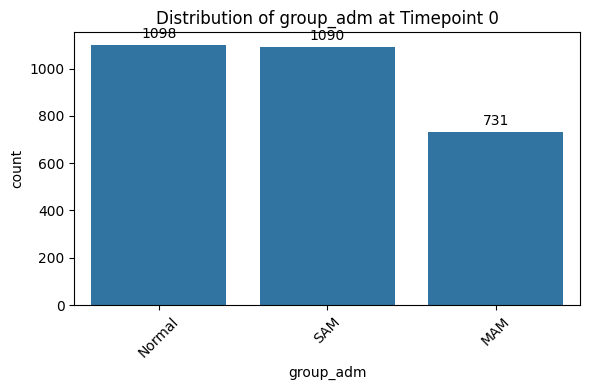

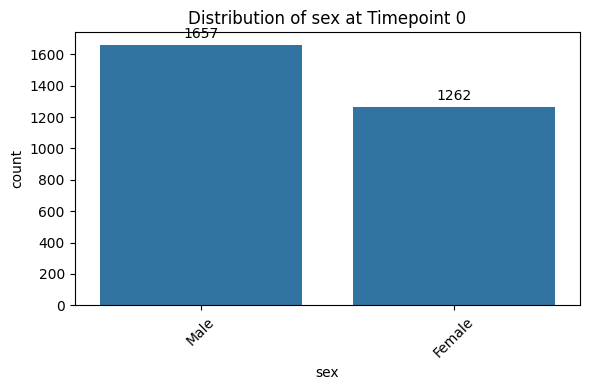

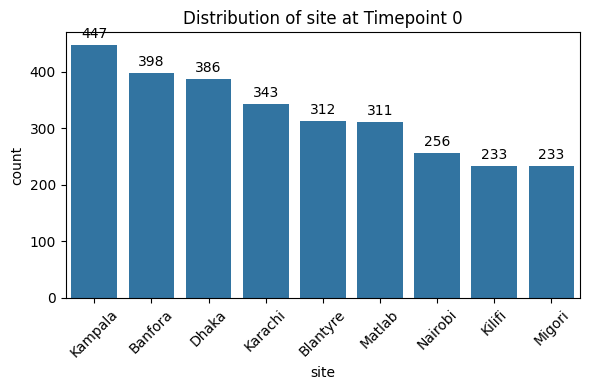

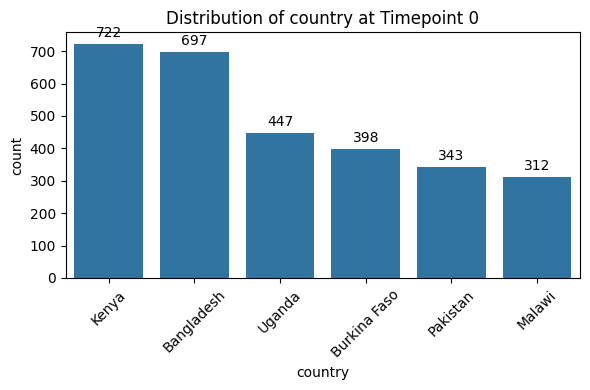

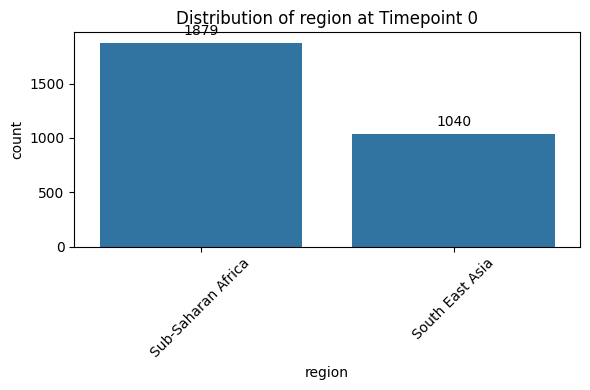

In [26]:
# Subset baseline only
baseline = long_data2[long_data2["timepoint"] == 0]

# Bar plots for categorical variables
categorical_vars = ["group_adm", "sex", "site", "country", "region"]
for var in categorical_vars:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=baseline, x=var, order=baseline[var].value_counts().index)
    plt.title(f"Distribution of {var} at Timepoint 0")
    plt.xticks(rotation=45)

    # Add text labels
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', padding=3)

    plt.tight_layout()
    plt.show()

In [27]:
# Identify categorical variables (excluding known continuous ones)
categorical_vars = [
    "sex", "group_adm", "site", "country", "region",
    "onoutpfeed_prog", "nutri_prog_disch", "nutri_counsel_disch",
    "oedema", "vomiting", "fever", "diarrhoea", "cough", "notfeeding",
    "poorfeeding", "part_appmnts_nutrition_followup", "hfoodshort_last_wk"
]

# Print unique values (levels) for each categorical variable
for var in categorical_vars:
    print(f"\n{var} levels:")
    print(sorted(long_data2[var].dropna().unique()))


sex levels:
['Female', 'Male']

group_adm levels:
['MAM', 'Normal', 'SAM']

site levels:
['Banfora', 'Blantyre', 'Dhaka', 'Kampala', 'Karachi', 'Kilifi', 'Matlab', 'Migori', 'Nairobi']

country levels:
['Bangladesh', 'Burkina Faso', 'Kenya', 'Malawi', 'Pakistan', 'Uganda']

region levels:
['South East Asia', 'Sub-Saharan Africa']

onoutpfeed_prog levels:
['No Feeding program', 'RUSF for MAM', 'RUTF for SAM']

nutri_prog_disch levels:
['None', 'Supplementary', 'Therapeutic']

nutri_counsel_disch levels:
['No', 'Yes']

oedema levels:
['+', '++', '+++', 'None']

vomiting levels:
['No', 'Yes']

fever levels:
['No', 'Yes']

diarrhoea levels:
['No', 'Yes']

cough levels:
['No', 'Yes']

notfeeding levels:
['No', 'Yes']

poorfeeding levels:
['No', 'Yes']

part_appmnts_nutrition_followup levels:
['No', 'Yes']

hfoodshort_last_wk levels:
['No', 'Unknown', 'Yes']


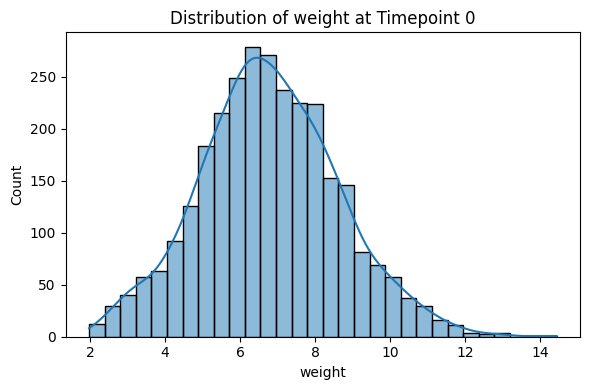

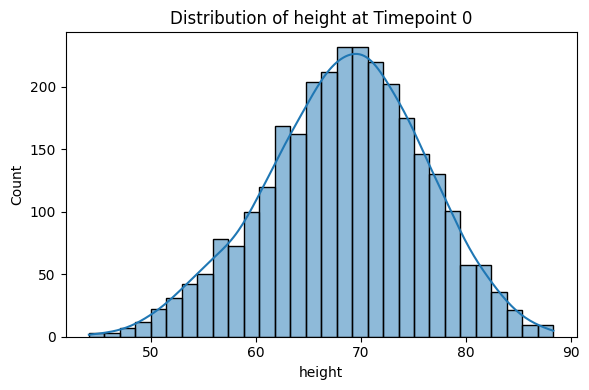

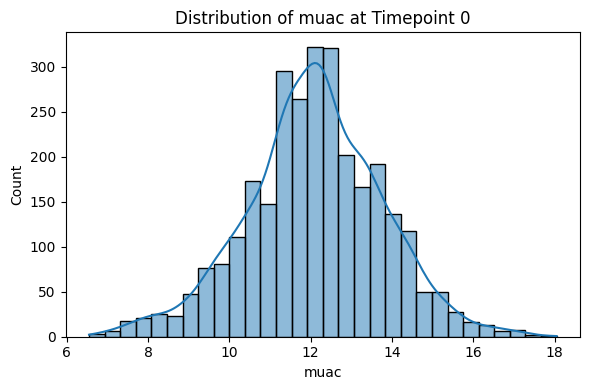

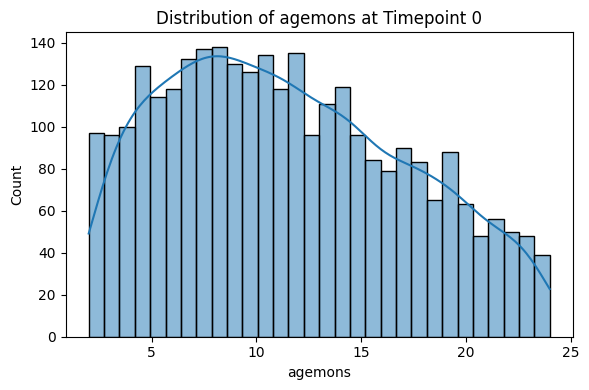

In [28]:
# Continuous variables
continuous_vars = ["weight", "height", "muac", "agemons"]
for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=baseline, x=var, kde=True, bins=30)
    plt.title(f"Distribution of {var} at Timepoint 0")
    plt.tight_layout()
    plt.show()

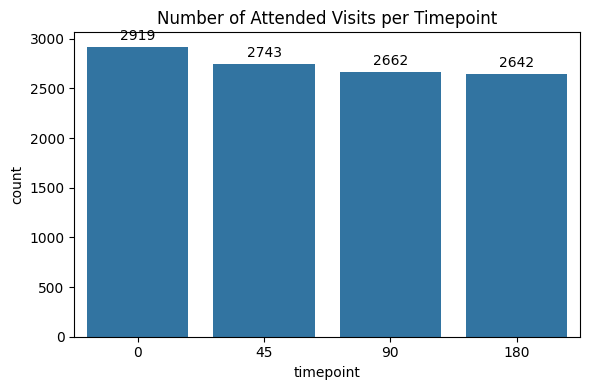

In [29]:
plt.figure(figsize=(6, 4))

# Filter to attended visits only
attended_data = long_data2[long_data2['missed_visit'] == 0]

# Plot count of attended visits per timepoint
ax = sns.countplot(data=attended_data, x="timepoint", order=sorted(attended_data["timepoint"].unique()))
plt.title("Number of Attended Visits per Timepoint")

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

plt.tight_layout()
plt.show()


In [30]:
# Create binary flags for missingness
long_data2["missing_weight"] = long_data2["weight"].isna()
long_data2["missing_height"] = long_data2["height"].isna()
long_data2["missing_muac"] = long_data2["muac"].isna()
long_data2["missing_oedema"] = long_data2["oedema"].isna()

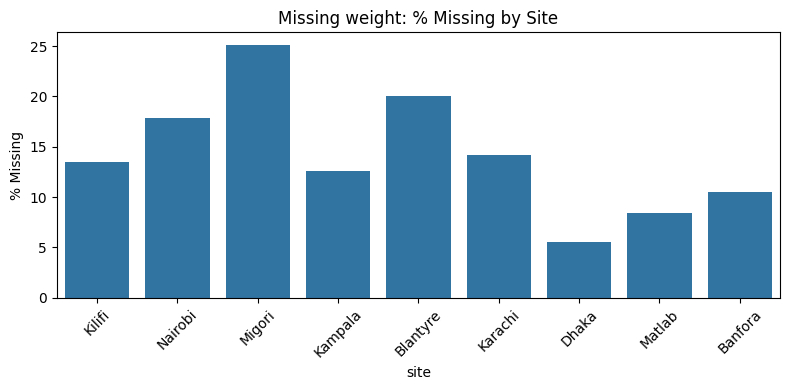

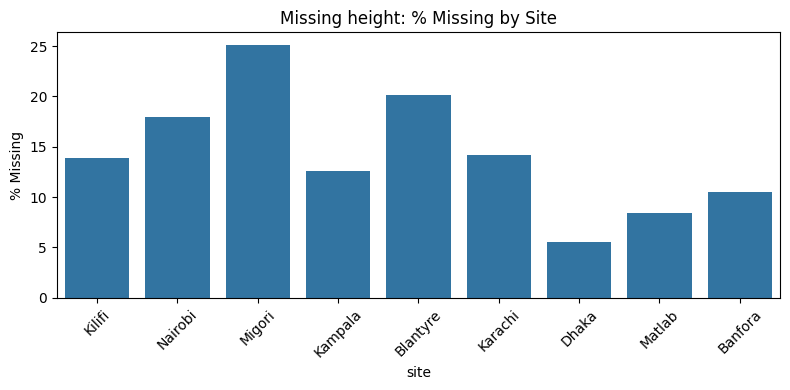

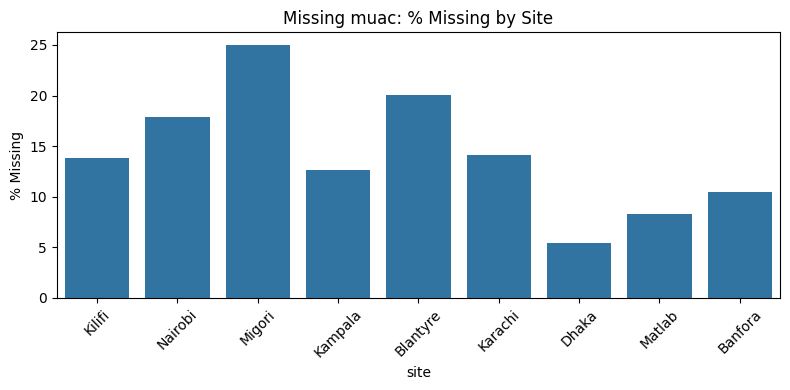

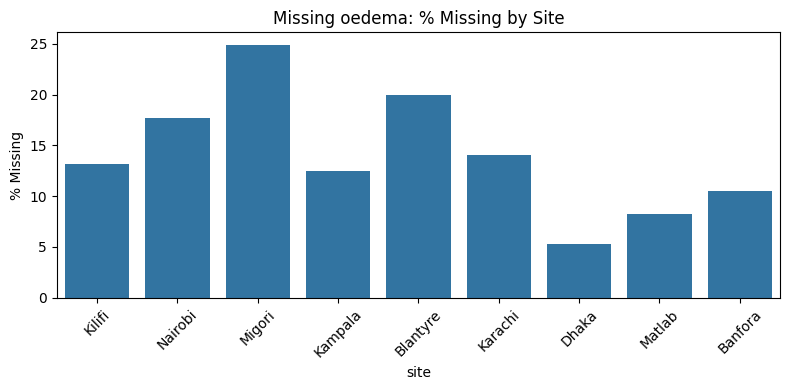

In [31]:
# Plot missingness rate per site for each variable
for var in ["missing_weight", "missing_height", "missing_muac", "missing_oedema"]:
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=long_data2,
        x="site",
        y=var,
        estimator=lambda x: x.mean() * 100,
        errorbar=None
    )
    plt.title(f"Missing {var.replace('missing_', '')}: % Missing by Site")
    plt.ylabel("% Missing")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

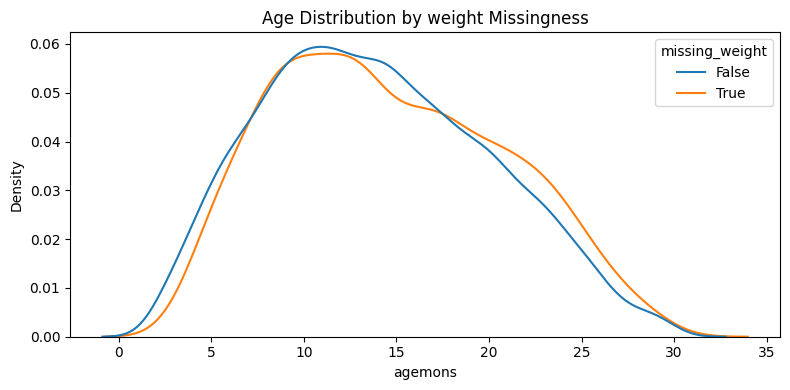

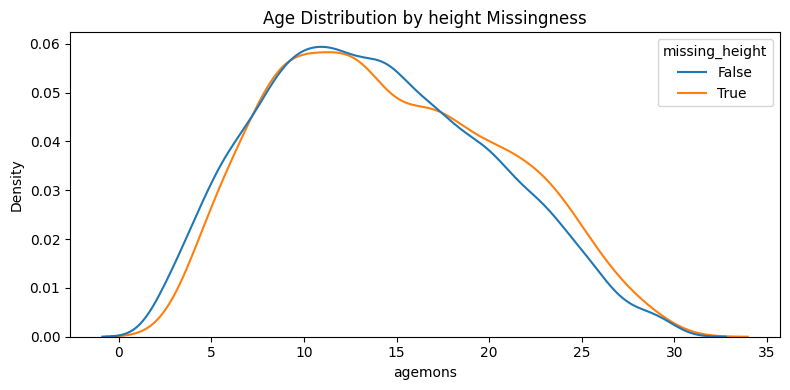

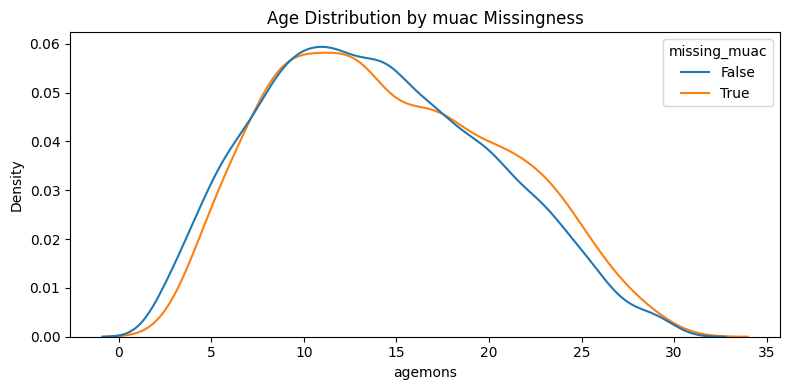

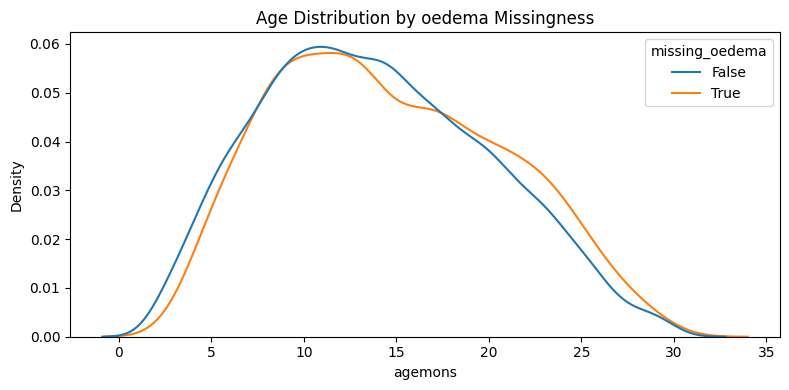

In [32]:
# Plot age distribution by missingness for each variable
for var in ["missing_weight", "missing_height", "missing_muac", "missing_oedema"]:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=long_data2, x="agemons", hue=var, common_norm=False)
    plt.title(f"Age Distribution by {var.replace('missing_', '')} Missingness")
    plt.tight_layout()
    plt.show()

## Missingness

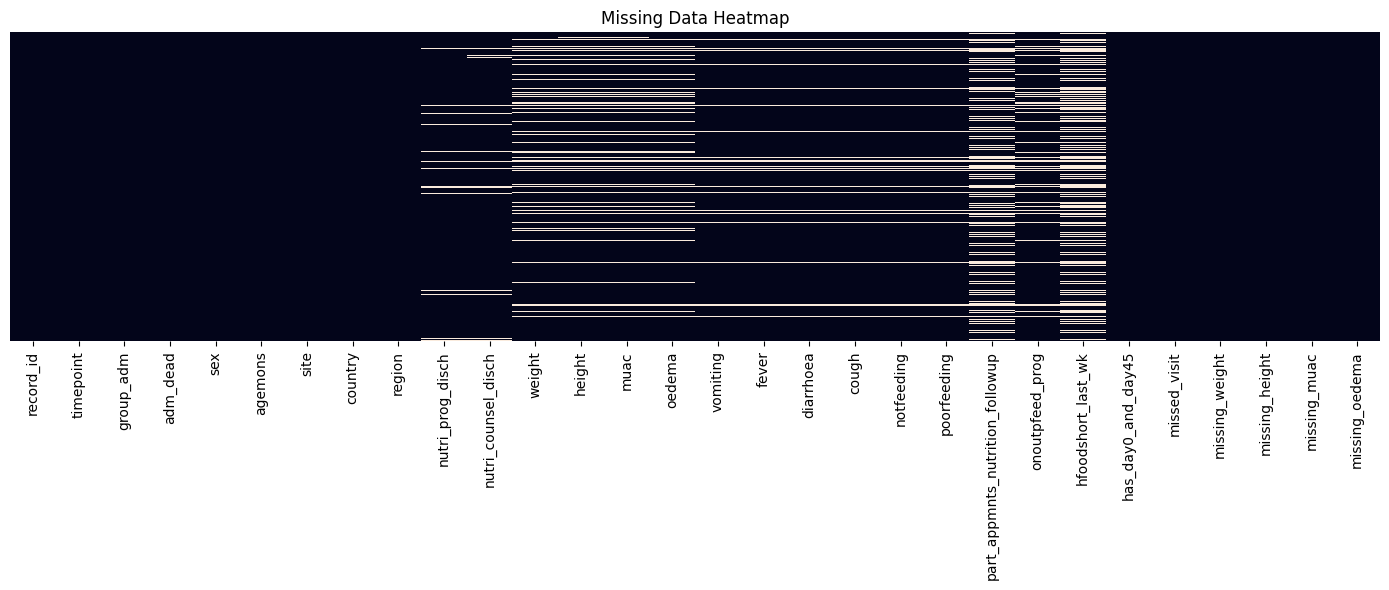

In [33]:
plt.figure(figsize=(14, 6))
sns.heatmap(long_data2.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.tight_layout()
plt.show()

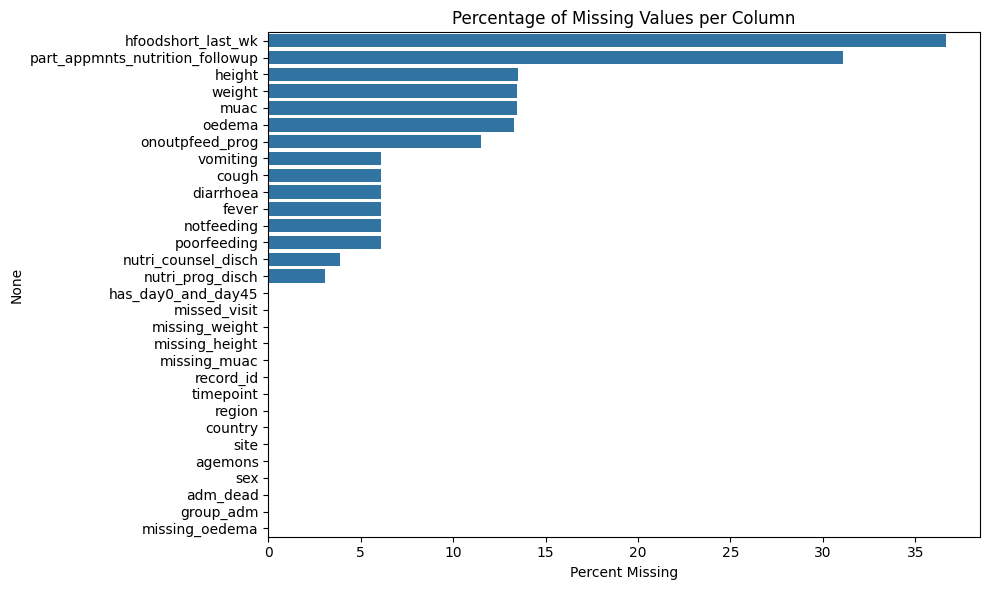

In [34]:
missing_pct = long_data2.isnull().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index)
plt.title("Percentage of Missing Values per Column")
plt.xlabel("Percent Missing")
plt.tight_layout()
plt.show()


In [35]:
missing_pct

hfoodshort_last_wk                 36.664954
part_appmnts_nutrition_followup    31.080850
height                             13.506338
weight                             13.446386
muac                               13.437821
oedema                             13.300788
onoutpfeed_prog                    11.485098
vomiting                            6.080850
cough                               6.080850
diarrhoea                           6.080850
fever                               6.080850
notfeeding                          6.080850
poorfeeding                         6.080850
nutri_counsel_disch                 3.905447
nutri_prog_disch                    3.083248
has_day0_and_day45                  0.000000
missed_visit                        0.000000
missing_weight                      0.000000
missing_height                      0.000000
missing_muac                        0.000000
record_id                           0.000000
timepoint                           0.000000
region    

> Drop columns with >20% missingness

In [36]:
drop_cols = ['hfoodshort_last_wk', 'part_appmnts_nutrition_followup']
long_data2 = long_data2.drop(columns=drop_cols)

C:\Users\cmuiruri\AppData\Local\Temp\ipykernel_2784\3309916674.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_timepoint = long_data2.groupby("timepoint").apply(lambda df: df.isnull().mean() * 100)


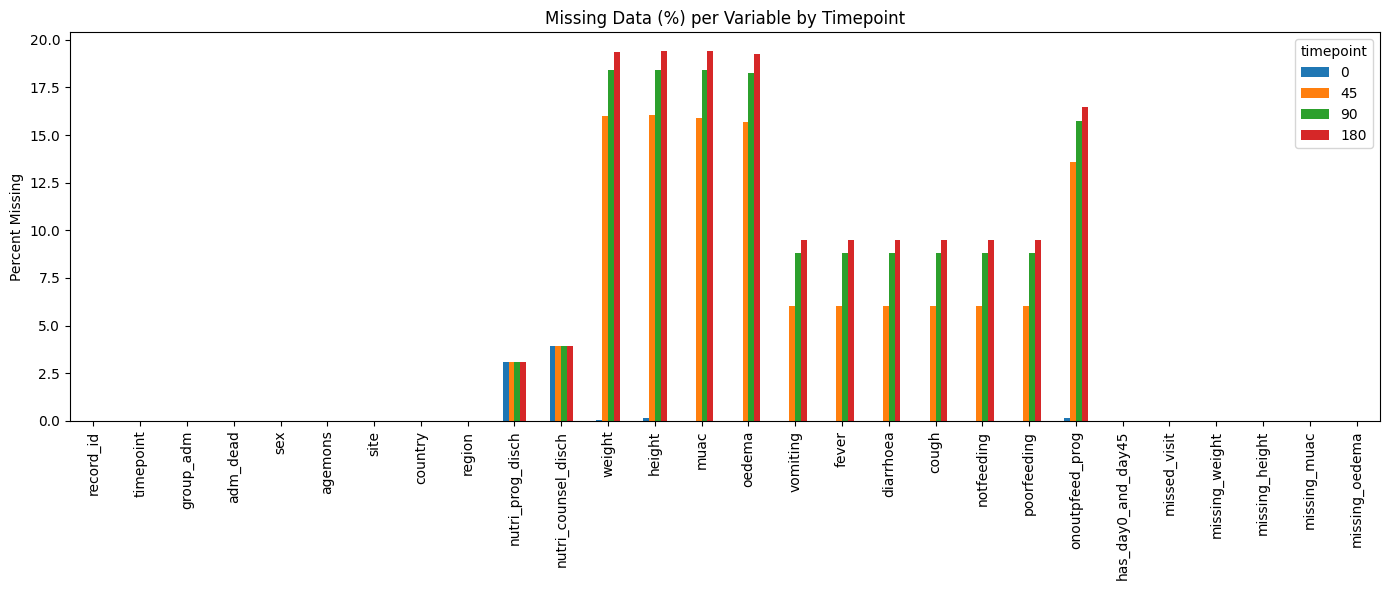

In [37]:
missing_by_timepoint = long_data2.groupby("timepoint").apply(lambda df: df.isnull().mean() * 100)

# Transpose and plot
missing_by_timepoint.T.plot(kind="bar", figsize=(14, 6))
plt.title("Missing Data (%) per Variable by Timepoint")
plt.ylabel("Percent Missing")
plt.tight_layout()
plt.show()


<Axes: >

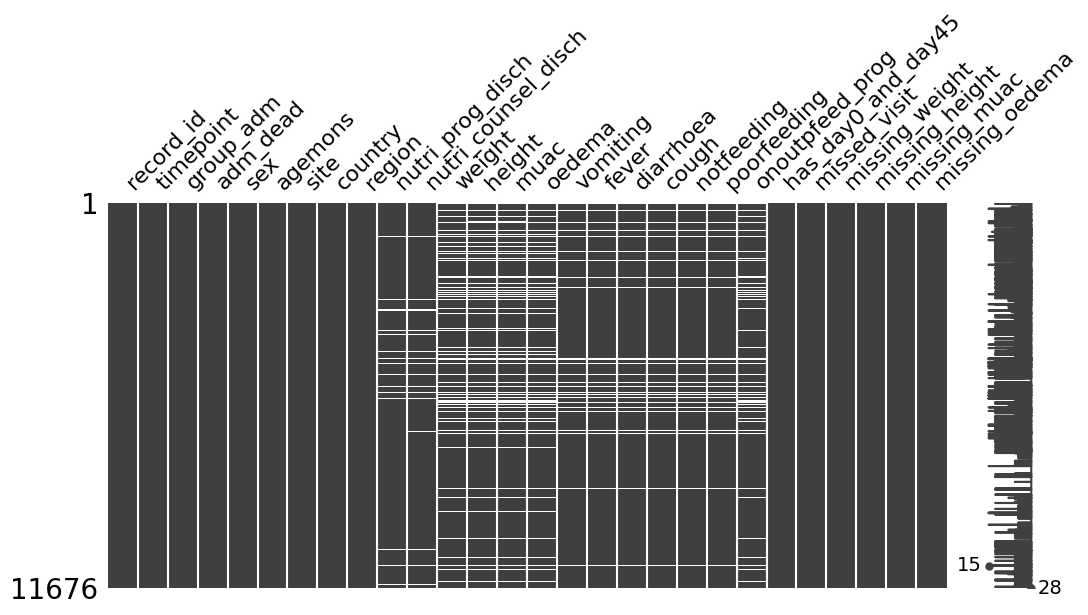

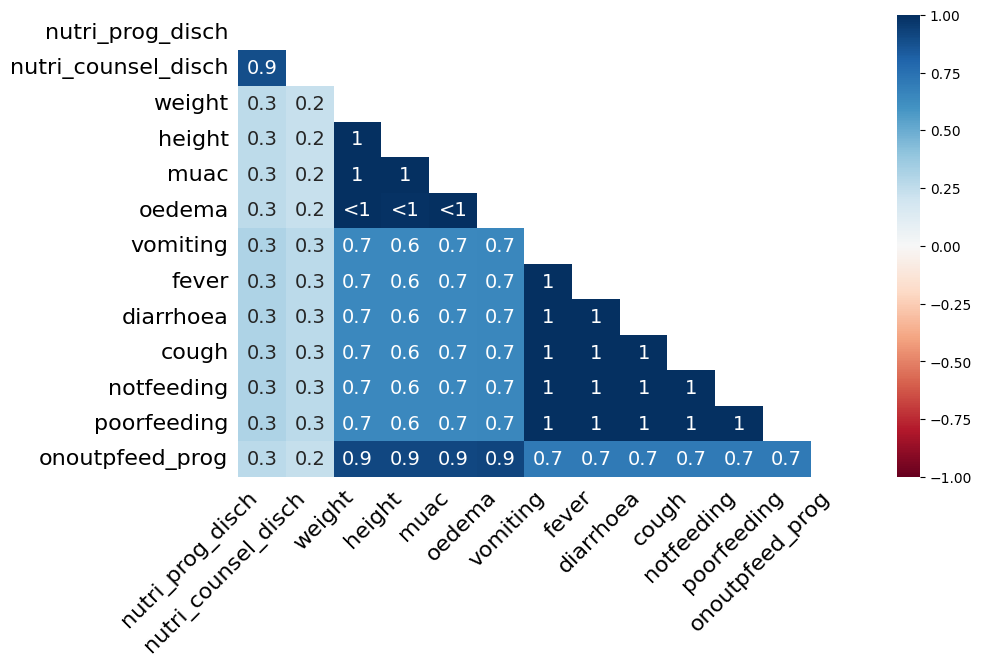

In [38]:
# Visual overview
msno.matrix(long_data2, figsize=(12, 5))
msno.heatmap(long_data2, figsize=(10, 6))


## Missing Data Pattern

In [39]:
timpoints = [0, 45, 90, 180]
visit_pivot = long_data2.pivot(index="record_id", columns="timepoint", values="missed_visit")
visit_pivot = visit_pivot[timepoints]
visit_pivot

timepoint,0,45,90,180
record_id,,,,
10001001,0,0,0,0
10001002,0,0,0,0
10001003,0,0,0,0
10001004,0,1,1,1
10001005,0,1,1,1
...,...,...,...,...
60001437,0,0,0,0
60001438,0,0,0,0
60001439,0,0,0,0


In [40]:
# Create pattern string for each row: O = completed, M = missed
def pattern(row):
    return ''.join(['O' if x == 0 else 'M' for x in row])

visit_pivot["Pattern"] = visit_pivot.apply(pattern, axis=1)

# Classify patterns
def classify(p):
    if p == "OOOO":
        return "Completers"
    elif p in ["OOOM", "OOMM", "OMMM"]:
        return "Dropout pattern"
    elif "M" in p and p not in ["OOOM", "OOMM", "OMMM", "OOOO"] and "O" in p[p.index("M")+1:]:
        return "Non-monotone pattern"
    else:
        return "Other"

In [41]:

visit_pivot["Category"] = visit_pivot["Pattern"].apply(classify)


# Count frequencies
summary = visit_pivot.groupby(["Category", "Pattern"]).size().reset_index(name="Count")

# Split pattern into columns
pattern_split = summary["Pattern"].apply(lambda x: pd.Series(list(x)))
pattern_split.columns = [str(tp) for tp in timepoints]

In [42]:
# Step 4: Filter for desired categories
selected_ids = visit_pivot[
    (visit_pivot["Pattern"] == "OOOO") |
    ((visit_pivot["Category"] == "Dropout pattern") & (visit_pivot["Pattern"] != "OMMM"))
].index

In [43]:
summary

,Category,Pattern,Count
0,Completers,OOOO,2597
1,Dropout pattern,OMMM,151
2,Dropout pattern,OOMM,73
3,Dropout pattern,OOOM,50
4,Non-monotone pattern,OMMO,10
5,Non-monotone pattern,OMOM,3
6,Non-monotone pattern,OMOO,12
7,Non-monotone pattern,OOMO,23


In [44]:
# Combine with summary
final_table = pd.concat([summary["Category"], pattern_split, summary["Count"]], axis=1)
final_table


,Category,0,45,90,180,Count
0,Completers,O,O,O,O,2597
1,Dropout pattern,O,M,M,M,151
2,Dropout pattern,O,O,M,M,73
3,Dropout pattern,O,O,O,M,50
4,Non-monotone pattern,O,M,M,O,10
5,Non-monotone pattern,O,M,O,M,3
6,Non-monotone pattern,O,M,O,O,12
7,Non-monotone pattern,O,O,M,O,23


In [45]:
# Pivot to wide format for weight
weight_pivot = long_data2.pivot(index="record_id", columns="timepoint", values="weight")

# Ensure columns are in the expected order
weight_pivot = weight_pivot[timepoints]

# Create pattern string: 'O' = observed, 'M' = missing
def pattern(row):
    return ''.join(['O' if pd.notna(x) else 'M' for x in row])

weight_pivot["Pattern"] = weight_pivot.apply(pattern, axis=1)

# Classify pattern into categories
def classify(p):
    if p == "OOOO":
        return "Completers"
    elif p in ["OOOM", "OOMM", "OMMM"]:
        return "Dropout pattern"
    elif "M" in p and p not in ["OOOO", "OOOM", "OOMM", "OMMM"] and "O" in p[p.index("M")+1:]:
        return "Non-monotone pattern"
    else:
        return "Other"

weight_pivot["Category"] = weight_pivot["Pattern"].apply(classify)

# Count occurrences
summary = weight_pivot.groupby(["Category", "Pattern"]).size().reset_index(name="Count")

# Split pattern into columns
pattern_split = summary["Pattern"].apply(lambda x: pd.Series(list(x)))
pattern_split.columns = [str(tp) for tp in timepoints]

# Combine with summary
final_weight_table = pd.concat([summary["Category"], pattern_split, summary["Count"]], axis=1)

# Display or export
final_weight_table


,Category,0,45,90,180,Count
0,Completers,O,O,O,O,2143
1,Dropout pattern,O,M,M,M,317
2,Dropout pattern,O,O,M,M,102
3,Dropout pattern,O,O,O,M,129
4,Non-monotone pattern,M,O,O,O,1
5,Non-monotone pattern,O,M,M,O,41
6,Non-monotone pattern,O,M,O,M,17
7,Non-monotone pattern,O,M,O,O,92
8,Non-monotone pattern,O,O,M,O,77


In [46]:
# Pivot to wide format for treat
treat_pivot = long_data2.pivot(index="record_id", columns="timepoint", values="onoutpfeed_prog")

# Ensure columns are in the expected order
treat_pivot = treat_pivot[timepoints]

# Create pattern string: 'O' = observed, 'M' = missing
def pattern(row):
    return ''.join(['O' if pd.notna(x) else 'M' for x in row])

treat_pivot["Pattern"] = treat_pivot.apply(pattern, axis=1)
treat_pivot["Category"] = treat_pivot["Pattern"].apply(classify)

# Count occurrences
summary = treat_pivot.groupby(["Category", "Pattern"]).size().reset_index(name="Count")

# Split pattern into columns
pattern_split2 = summary["Pattern"].apply(lambda x: pd.Series(list(x)))
pattern_split2.columns = [str(tp) for tp in timepoints]

# Combine with summary
final_treat_table = pd.concat([summary["Category"], pattern_split2, summary["Count"]], axis=1)

# Display or export
final_treat_table

,Category,0,45,90,180,Count
0,Completers,O,O,O,O,2252
1,Dropout pattern,O,M,M,M,267
2,Dropout pattern,O,O,M,M,90
3,Dropout pattern,O,O,O,M,104
4,Non-monotone pattern,M,O,M,M,2
5,Non-monotone pattern,M,O,O,O,2
6,Non-monotone pattern,O,M,M,O,28
7,Non-monotone pattern,O,M,O,M,18
8,Non-monotone pattern,O,M,O,O,83
9,Non-monotone pattern,O,O,M,O,73


In [47]:
completeobs = long_data2.dropna()

## Missingness Mechanism Exploration
### Goal is to understand whether data are MCAR, MAR, or MNAR

1. Flag Missingness for each key variable

In [48]:
import statsmodels.formula.api as smf

# Step 1: List target variables to assess missingness
key_vars = [
    'weight', 'height', 'muac', 'oedema', 'vomiting',
    'fever', 'diarrhoea', 'cough', 'notfeeding',
    'poorfeeding', 'onoutpfeed_prog', 'nutri_prog_disch',
    'nutri_counsel_disch'
]

# Step 2: Create missingness indicators
for var in key_vars:
    long_data2[f'missing_{var}'] = long_data2[var].isna().astype(int)

# Step 3: Define predictors — INCLUDE site and region
predictors = ['C(timepoint)', 'C(sex)', 'C(site)', 'C(region)', 'agemons', 'C(group_adm)']

# Step 4: Run logistic regression for each missingness indicator
missingness_models = {}

for var in key_vars:
    flag = f'missing_{var}'
    try:
        formula = f"{flag} ~ {' + '.join(predictors)}"
        model = smf.logit(formula=formula, data=long_data2).fit(disp=False)
        missingness_models[var] = model
        print(f"\n=== Missingness Model for {var} ===")
        print(model.summary())
    except Exception as e:
        print(f"Model failed for {var}: {e}")




=== Missingness Model for weight ===
                           Logit Regression Results                           
Dep. Variable:         missing_weight   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1475
Time:                        15:06:41   Log-Likelihood:                -3929.5
converged:                       True   LL-Null:                       -4609.5
Covariance Type:            nonrobust   LLR p-value:                6.631e-280
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -6.7895        nan        nan        nan         nan         nan
C(timepoint)[T.45]            

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for muac ===
                           Logit Regression Results                           
Dep. Variable:           missing_muac   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1498
Time:                        15:06:42   Log-Likelihood:                -3917.4
converged:                      False   LL-Null:                       -4607.6
Covariance Type:            nonrobust   LLR p-value:                2.519e-284
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -20.7092    1.5e+06  -1.38e-05      1.000   -2.94e+06    2.94e+06
C(timepoint)[T.45]              

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for oedema ===
                           Logit Regression Results                           
Dep. Variable:         missing_oedema   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1496
Time:                        15:06:42   Log-Likelihood:                -3892.9
converged:                      False   LL-Null:                       -4577.7
Covariance Type:            nonrobust   LLR p-value:                5.253e-282
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -20.6909        nan        nan        nan         nan         nan
C(timepoint)[T.45]            

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for vomiting ===
                           Logit Regression Results                           
Dep. Variable:       missing_vomiting   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1673
Time:                        15:06:42   Log-Likelihood:                -2228.3
converged:                      False   LL-Null:                       -2676.0
Covariance Type:            nonrobust   LLR p-value:                2.626e-180
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -21.6796        nan        nan        nan         nan         nan
C(timepoint)[T.45]          

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for fever ===
                           Logit Regression Results                           
Dep. Variable:          missing_fever   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1673
Time:                        15:06:42   Log-Likelihood:                -2228.3
converged:                      False   LL-Null:                       -2676.0
Covariance Type:            nonrobust   LLR p-value:                2.626e-180
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -21.6796        nan        nan        nan         nan         nan
C(timepoint)[T.45]             

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for diarrhoea ===
                           Logit Regression Results                           
Dep. Variable:      missing_diarrhoea   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1673
Time:                        15:06:43   Log-Likelihood:                -2228.3
converged:                      False   LL-Null:                       -2676.0
Covariance Type:            nonrobust   LLR p-value:                2.626e-180
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -21.6796        nan        nan        nan         nan         nan
C(timepoint)[T.45]         

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for cough ===
                           Logit Regression Results                           
Dep. Variable:          missing_cough   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1673
Time:                        15:06:43   Log-Likelihood:                -2228.3
converged:                      False   LL-Null:                       -2676.0
Covariance Type:            nonrobust   LLR p-value:                2.626e-180
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -21.6796        nan        nan        nan         nan         nan
C(timepoint)[T.45]             

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for notfeeding ===
                           Logit Regression Results                           
Dep. Variable:     missing_notfeeding   No. Observations:                11676
Model:                          Logit   Df Residuals:                    11659
Method:                           MLE   Df Model:                           16
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1673
Time:                        15:06:44   Log-Likelihood:                -2228.3
converged:                      False   LL-Null:                       -2676.0
Covariance Type:            nonrobust   LLR p-value:                2.626e-180
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -21.6796        nan        nan        nan         nan         nan
C(timepoint)[T.45]        

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Missingness Model for poorfeeding ===
                            Logit Regression Results                           
Dep. Variable:     missing_poorfeeding   No. Observations:                11676
Model:                           Logit   Df Residuals:                    11659
Method:                            MLE   Df Model:                           16
Date:                 Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1673
Time:                         15:06:44   Log-Likelihood:                -2228.3
converged:                       False   LL-Null:                       -2676.0
Covariance Type:             nonrobust   LLR p-value:                2.626e-180
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -21.6796        nan        nan        nan         nan         nan
C(timepoint)[T.45

Since outcome(Percentage weight gain) will be derived from weight. To perform the Sensitivity analysis we will have to impute missing weight .

In [49]:
# Create a wide format of weight (e.g., weight_0, weight_45, ...)
weight_wide = long_data2.pivot(index='record_id', columns='timepoint', values='weight')
imp = IterativeImputer(max_iter=10, random_state=0)
weight_imputed = pd.DataFrame(imp.fit_transform(weight_wide), columns=weight_wide.columns, index=weight_wide.index)

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Apply delta shifts(MNAR) to imputed weight

In [50]:
weight_mnar = {}
for delta in [-0.5, -0.25, 0, 0.25, 0.5]:
    adjusted = weight_imputed.copy()
    adjusted[weight_wide.isna()] += delta  # shift only where original was missing
    weight_mnar[delta] = adjusted


In [51]:
def compute_pct_gains(df):
    gains = pd.DataFrame(index=df.index)
    
    if 0 in df.columns and 45 in df.columns:
        gains['pct_gain_0_45'] = ((df[45] - df[0]) / 2 * 100)
    if 45 in df.columns and 90 in df.columns:
        gains['pct_gain_45_90'] = ((df[90] - df[45]) / 2 * 100)
    if 90 in df.columns and 180 in df.columns:
        gains['pct_gain_90_180'] = ((df[180] - df[90]) / 2 * 100)
    
    return gains


In [52]:
pct_gain_scenarios = {
    delta: compute_pct_gains(weight_mnar[delta]) for delta in weight_mnar
}

In [53]:
long_data2['binary_treatment'] = long_data2['onoutpfeed_prog'].replace({
    'No Feeding program': 0,
    'RUSF for MAM': 1,
    'RUTF for SAM': 1
})

C:\Users\cmuiruri\AppData\Local\Temp\ipykernel_2784\2472438005.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data2['binary_treatment'] = long_data2['onoutpfeed_prog'].replace({


In [54]:
# Get participant-level covariates from timepoint 0
covariates_df = long_data2[long_data2['timepoint'] == 0].drop_duplicates('record_id')
covariates_df = covariates_df.set_index('record_id')

# Merge gain values into covariates
analysis_frames = {}
for delta, pct_df in pct_gain_scenarios.items():
    merged = covariates_df.join(pct_df)
    analysis_frames[delta] = merged

In [55]:
# Define all covariates to include in the model
covariates = [
    'binary_treatment', 'agemons', 'C(site)', 
    'C(nutri_counsel_disch)', 'height', 'muac', 
    'C(oedema)', 'C(vomiting)', 'C(diarrhoea)'
]

for delta, df in analysis_frames.items():
    print(f"\n=== Delta {delta:+.2f} ===")
    for outcome in ['pct_gain_0_45', 'pct_gain_45_90', 'pct_gain_90_180']:
        if outcome in df.columns:
            formula = f"{outcome} ~ " + " + ".join(covariates)
            try:
                model = smf.ols(formula, data=df).fit()
                print(f"\nOutcome: {outcome}")
                print(model.summary().tables[1])
            except Exception as e:
                print(f"Model failed for {outcome} at delta {delta}: {e}")


=== Delta -0.50 ===

Outcome: pct_gain_0_45
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       105.3049      8.703     12.099      0.000      88.239     122.371
C(site)[T.Blantyre]              -4.6252      2.430     -1.904      0.057      -9.389       0.139
C(site)[T.Dhaka]                 -1.5596      2.392     -0.652      0.514      -6.249       3.130
C(site)[T.Kampala]               -1.1956      2.223     -0.538      0.591      -5.555       3.164
C(site)[T.Karachi]              -11.9326      2.390     -4.993      0.000     -16.618      -7.247
C(site)[T.Kilifi]                -3.1990      2.591     -1.235      0.217      -8.279       1.881
C(site)[T.Matlab]                -6.9941      2.427     -2.882      0.004     -11.754      -2.235
C(site)[T.Migori]               -10.1824      2.536     -4.016      0.000

In [56]:
from tableone import TableOne

columns = ['sex', 'site', 'region', 'agemons', 'weight','height', 'muac']
categorical = ['sex', 'site', 'region']
df_attended = long_data2[long_data2['missed_visit'] != 1].copy()
# Loop over binary_outcome levels

table1 = TableOne(
    data=df_attended,
    columns=columns,
    categorical=categorical,
    groupby='timepoint',
    overall=True
)
    
print(table1.tabulate(tablefmt="github"))

|                    |                    | Missing   | Overall     | 0           | 180         | 45          | 90          |
|--------------------|--------------------|-----------|-------------|-------------|-------------|-------------|-------------|
| n                  |                    |           | 10966       | 2919        | 2642        | 2743        | 2662        |
| sex, n (%)         | Female             |           | 4726 (43.1) | 1262 (43.2) | 1132 (42.8) | 1185 (43.2) | 1147 (43.1) |
|                    | Male               |           | 6240 (56.9) | 1657 (56.8) | 1510 (57.2) | 1558 (56.8) | 1515 (56.9) |
| site, n (%)        | Banfora            |           | 1541 (14.1) | 398 (13.6)  | 374 (14.2)  | 387 (14.1)  | 382 (14.4)  |
|                    | Blantyre           |           | 1044 (9.5)  | 312 (10.7)  | 233 (8.8)   | 270 (9.8)   | 229 (8.6)   |
|                    | Dhaka              |           | 1509 (13.8) | 386 (13.2)  | 373 (14.1)  | 376 (13.7)  | 374 (1

In [57]:
long_data2.drop(columns=["binary_treatment"], inplace=True)

# Drop all 'missing_*' columns from long_data permanently
long_data2.drop(columns=[col for col in long_data2.columns if "missing" in col], inplace=True)

MAR confirmed

In [58]:
long_data2.columns

Index(['record_id', 'timepoint', 'group_adm', 'adm_dead', 'sex', 'agemons',
       'site', 'country', 'region', 'nutri_prog_disch', 'nutri_counsel_disch',
       'weight', 'height', 'muac', 'oedema', 'vomiting', 'fever', 'diarrhoea',
       'cough', 'notfeeding', 'poorfeeding', 'onoutpfeed_prog',
       'has_day0_and_day45', 'missed_visit'],
      dtype='object')

## Imputation

In [59]:
# Columns with missing values
missing_cols = [
    'weight', 'height', 'muac', 'oedema', 'vomiting',
    'fever', 'diarrhoea', 'cough', 'notfeeding',
    'poorfeeding', 'onoutpfeed_prog', 'nutri_prog_disch',
    'nutri_counsel_disch'
]

# Categorical and numerical split
categorical_cols = [
    'oedema', 'vomiting', 'fever', 'diarrhoea', 'cough',
    'notfeeding', 'poorfeeding', 'onoutpfeed_prog',
    'nutri_prog_disch', 'nutri_counsel_disch'
]
numerical_cols = ['weight', 'height', 'muac']

# Filter: Only participants with both Day 0 and Day 45
data_imp = long_data2[long_data2["has_day0_and_day45"] == 1].copy()

# Convert categoricals to category dtype while preserving NaNs
for col in categorical_cols:
    data_imp[col] = data_imp[col].astype("category")

# Save original category labels
category_maps = {col: data_imp[col].cat.categories.tolist() for col in categorical_cols}

# Ordinal encode (preserving NaNs)
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
data_imp[categorical_cols] = encoder.fit_transform(data_imp[categorical_cols])

# Add timepoint and record_id numerical encodings to inform MICE
data_imp["timepoint_num"] = pd.to_numeric(data_imp["timepoint"])
data_imp["record_id_num"] = data_imp["record_id"].astype("category").cat.codes

# Define predictors for imputation
impute_cols = numerical_cols + categorical_cols + ["timepoint_num", "record_id_num"]

# Run MICE
imputer = IterativeImputer(max_iter=10, random_state=0)
data_imp[impute_cols] = imputer.fit_transform(data_imp[impute_cols])

# Decode categorical columns back to original categories
for col_idx, col in enumerate(categorical_cols):
    categories = category_maps[col]
    data_imp[col] = data_imp[col].round().clip(0, len(categories) - 1).astype("Int64")
    data_imp[col] = data_imp[col].map(dict(enumerate(categories)))

# Drop helper columns
data_imp.drop(columns=["record_id_num", "timepoint_num"], inplace=True)

# Create binary treatment variable
data_imp["binary_treatment"] = (data_imp["onoutpfeed_prog"] != "No Feeding program").astype(int)

# Sort for lag calculation
data_imp = data_imp.sort_values(by=["record_id", "timepoint"]).reset_index(drop=True)

# Calculate % weight gain
data_imp["prev_weight"] = data_imp.groupby("record_id")["weight"].shift(1)
data_imp["pct_weight_gain"] = np.where(
    data_imp["timepoint"] == 0,
    0,
    100 * (data_imp["weight"] - data_imp["prev_weight"]) / data_imp["prev_weight"]
)
data_imp.drop(columns=["prev_weight"], inplace=True)

In [60]:
# Filter the dataset for timepoint == 0
data_imp_t0 = data_imp[data_imp['timepoint'] == 45]

# Generate frequency tables for categorical columns at timepoint == 0
cat_freq_tables_t0 = {
    col: data_imp_t0[col].value_counts(dropna=False).reset_index().rename(columns={"index": col, col: "count"})
    for col in categorical_cols
}

# Display all tables
for col, table in cat_freq_tables_t0.items():
    print(f"\n=== Frequency Table for {col} (timepoint == 45) ===")
    display(table)


=== Frequency Table for oedema (timepoint == 45) ===


,count,count
0,None,2906
1,+,12
2,+++,1



=== Frequency Table for vomiting (timepoint == 45) ===


,count,count
0,No,2846
1,Yes,73



=== Frequency Table for fever (timepoint == 45) ===


,count,count
0,No,2571
1,Yes,348



=== Frequency Table for diarrhoea (timepoint == 45) ===


,count,count
0,No,2770
1,Yes,149



=== Frequency Table for cough (timepoint == 45) ===


,count,count
0,No,2492
1,Yes,427



=== Frequency Table for notfeeding (timepoint == 45) ===


,count,count
0,No,2896
1,Yes,23



=== Frequency Table for poorfeeding (timepoint == 45) ===


,count,count
0,No,2882
1,Yes,37



=== Frequency Table for onoutpfeed_prog (timepoint == 45) ===


,count,count
0,No Feeding program,2370
1,RUTF for SAM,341
2,RUSF for MAM,208



=== Frequency Table for nutri_prog_disch (timepoint == 45) ===


,count,count
0,None,2207
1,Therapeutic,559
2,Supplementary,153



=== Frequency Table for nutri_counsel_disch (timepoint == 45) ===


,count,count
0,Yes,2013
1,No,906


In [61]:
# Frequency table for each categorical column
cat_freq_tables = {col: data_imp[col].value_counts(dropna=False).reset_index().rename(columns={"index": col, col: "count"}) for col in categorical_cols}

# Display all tables
for col, table in cat_freq_tables.items():
    print(f"\n=== Frequency Table for {col} ===")
    display(table)


=== Frequency Table for oedema ===


,count,count
0,None,11335
1,+,131
2,++,122
3,+++,88



=== Frequency Table for vomiting ===


,count,count
0,No,10196
1,Yes,1480



=== Frequency Table for fever ===


,count,count
0,No,8459
1,Yes,3217



=== Frequency Table for diarrhoea ===


,count,count
0,No,9764
1,Yes,1912



=== Frequency Table for cough ===


,count,count
0,No,9071
1,Yes,2605



=== Frequency Table for notfeeding ===


,count,count
0,No,11450
1,Yes,226



=== Frequency Table for poorfeeding ===


,count,count
0,No,11075
1,Yes,601



=== Frequency Table for onoutpfeed_prog ===


,count,count
0,No Feeding program,10288
1,RUTF for SAM,755
2,RUSF for MAM,633



=== Frequency Table for nutri_prog_disch ===


,count,count
0,None,8810
1,Therapeutic,2229
2,Supplementary,637



=== Frequency Table for nutri_counsel_disch ===


,count,count
0,Yes,8041
1,No,3635


Explore if suspect MNAR are from one site. Measurement errors etc

Can be ignored

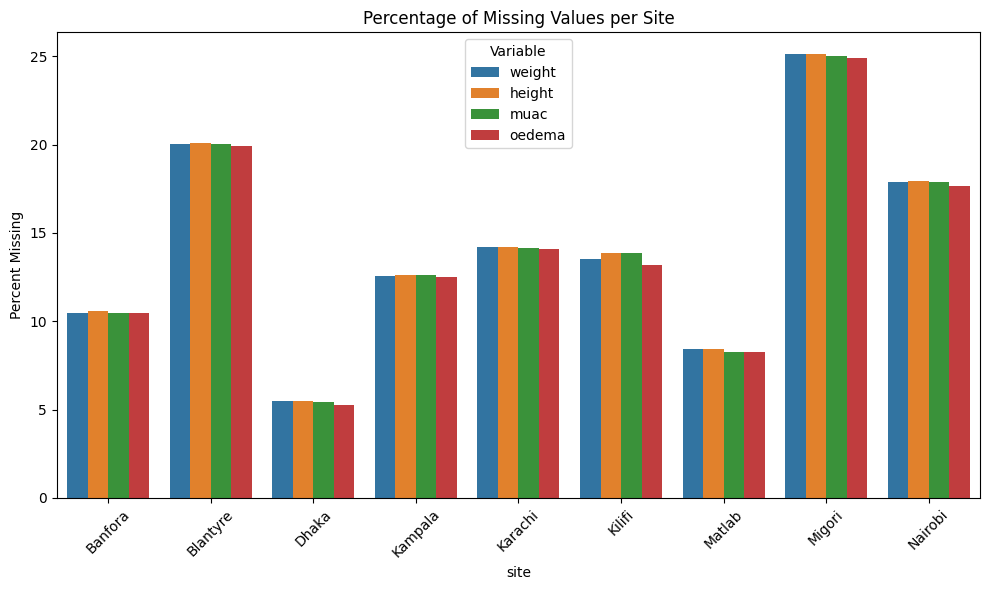

In [62]:
# Select target variables
target_vars = ["weight", "height", "muac", "oedema"]

# Compute missingness per site
missing_by_site = long_data2.groupby("site")[target_vars].apply(lambda df: df.isnull().mean() * 100).reset_index()

# Melt for seaborn plotting
missing_melted = missing_by_site.melt(id_vars="site", var_name="variable", value_name="missing_pct")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=missing_melted, x="site", y="missing_pct", hue="variable")
plt.title("Percentage of Missing Values per Site")
plt.ylabel("Percent Missing")
plt.xticks(rotation=45)
plt.legend(title="Variable")
plt.tight_layout()
plt.show()


# Outcome Aware EDA

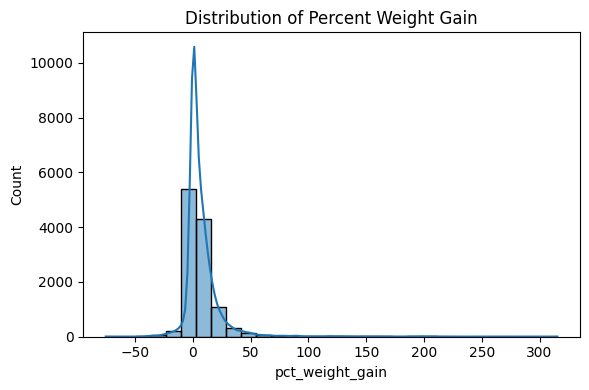

In [63]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data_imp, x="pct_weight_gain", kde=True, bins=30)
plt.title("Distribution of Percent Weight Gain")
plt.tight_layout()
plt.show()

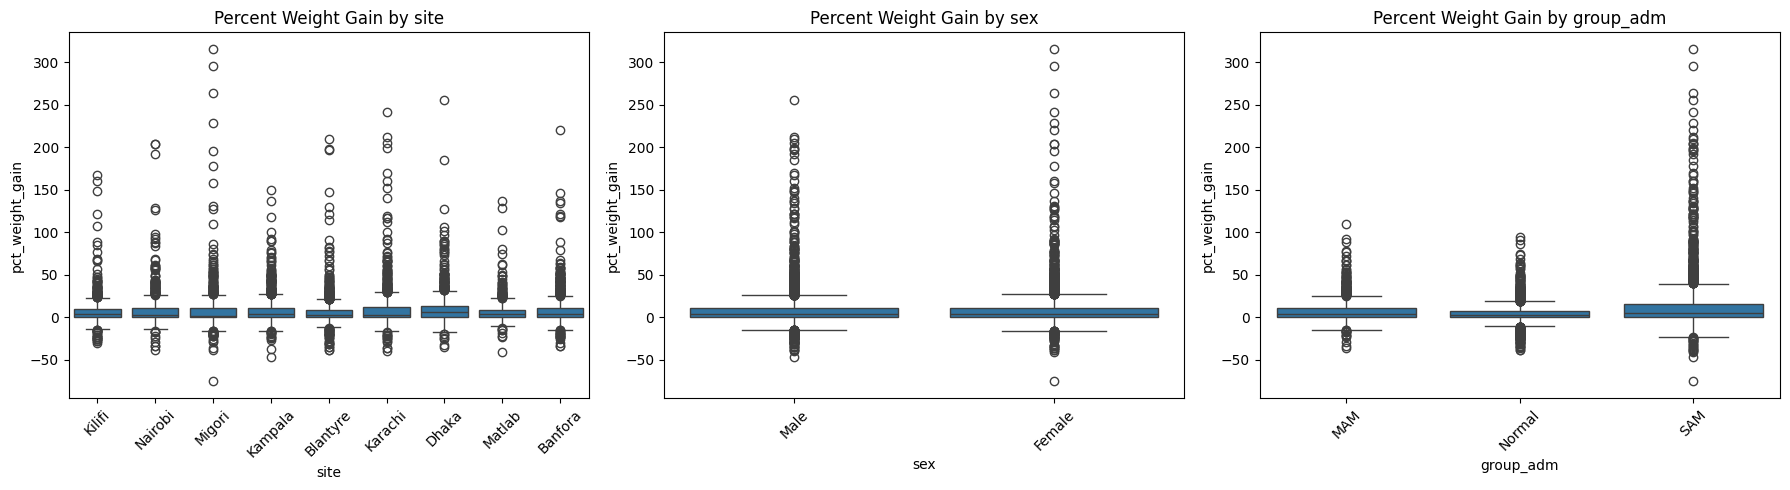

In [64]:
categorical_vars = ["site", "sex", "group_adm"]

# Set up subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot each boxplot
for i, var in enumerate(categorical_vars):
    sns.boxplot(data=data_imp, x=var, y="pct_weight_gain", ax=axes[i])
    axes[i].set_title(f"Percent Weight Gain by {var}")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

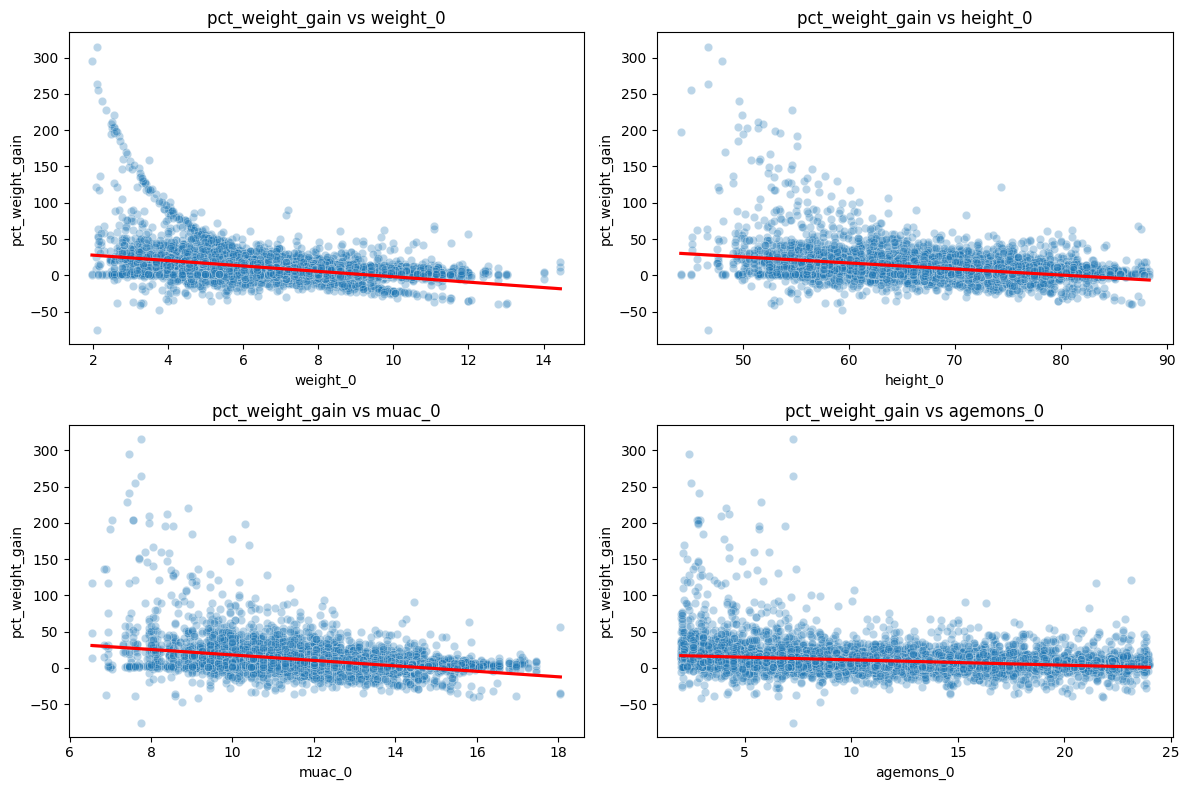

In [65]:
# Use baseline values for x, but exclude timepoint 0 for the y (pct_weight_gain)
predictors = ["weight", "height", "muac", "agemons"]

# Merge baseline predictors into all timepoints
baseline = data_imp[data_imp["timepoint"] == 0][["record_id"] + predictors].copy()
baseline.columns = ["record_id"] + [f"{col}_0" for col in predictors]

# Merge with long_data for y values
long_augmented = pd.merge(data_imp, baseline, on="record_id", how="left")

# Filter to timepoints > 0 (where pct_weight_gain is meaningful)
long_augmented = long_augmented[long_augmented["timepoint"] > 0]

# Set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each
for i, var in enumerate(predictors):
    x = f"{var}_0"
    sns.scatterplot(data=long_augmented, x=x, y="pct_weight_gain", alpha=0.3, ax=axes[i])
    sns.regplot(data=long_augmented, x=x, y="pct_weight_gain", scatter=False, color="red", ax=axes[i])
    axes[i].set_title(f"pct_weight_gain vs {x}")

plt.tight_layout()
plt.show()

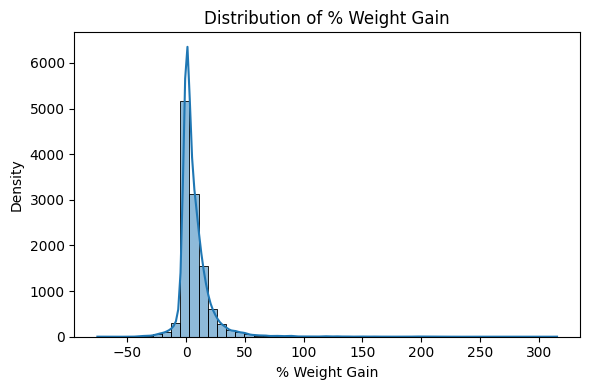

In [ ]:
# Filter for records with valid outcome
df = data_imp[data_imp['pct_weight_gain'].notna()].copy()

# Distribution of Outcome
plt.figure(figsize=(6, 4))
sns.histplot(df['pct_weight_gain'], bins=50, kde=True)
plt.title("Distribution of % Weight Gain")
plt.xlabel("% Weight Gain")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

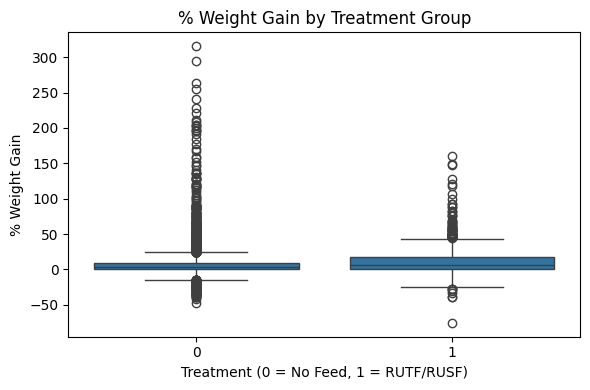

In [ ]:
# Outcome Across Treatment Groups
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='binary_treatment', y='pct_weight_gain')
plt.title("% Weight Gain by Treatment Group")
plt.xlabel("Treatment (0 = No Feed, 1 = RUTF/RUSF)")
plt.ylabel("% Weight Gain")
plt.tight_layout()
plt.show()

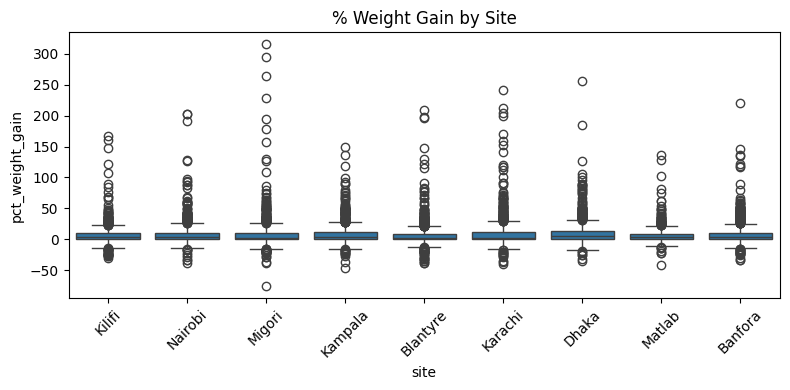

In [ ]:
# Site-wise Outcome Patterns
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='site', y='pct_weight_gain')
plt.xticks(rotation=45)
plt.title("% Weight Gain by Site")
plt.tight_layout()
plt.show()



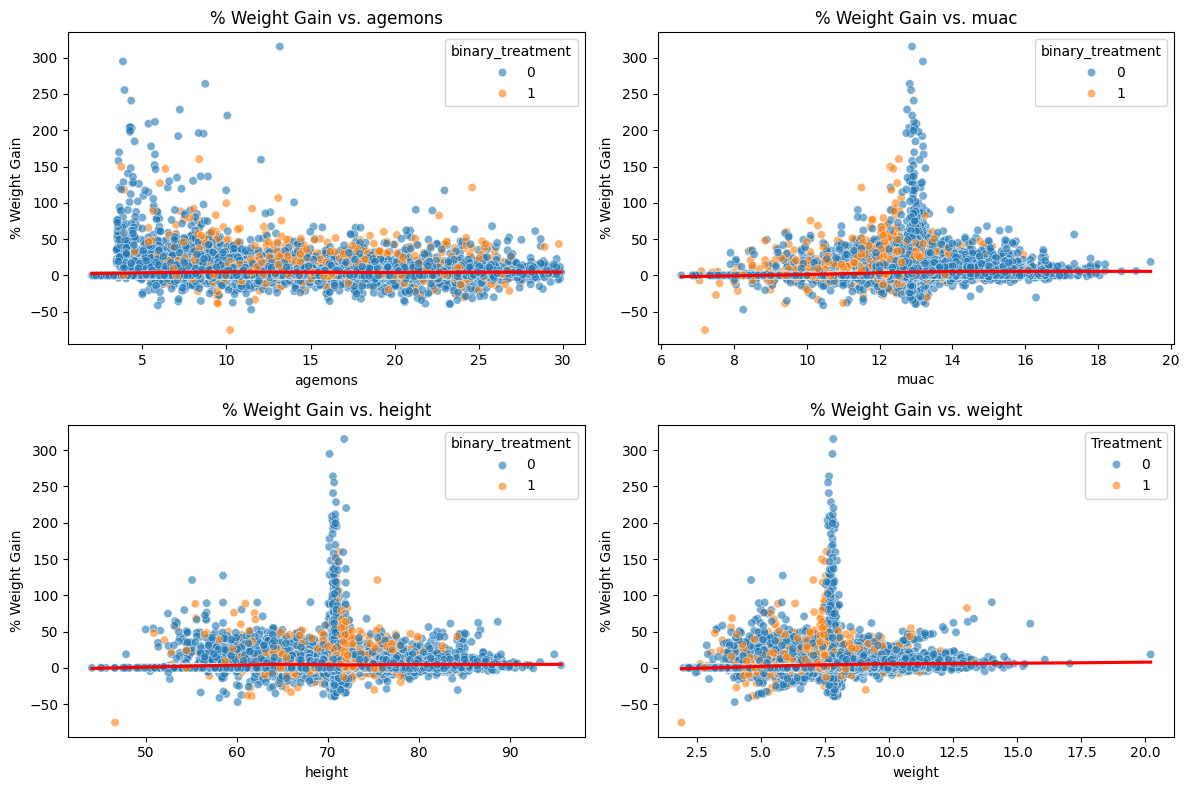

In [ ]:
# Relationship with Key Covariates - using subplots
covariates = ['agemons', 'muac', 'height', 'weight']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, cov in enumerate(covariates):
    sns.scatterplot(data=df, x=cov, y='pct_weight_gain', hue='binary_treatment', alpha=0.6, ax=axes[i])
    sns.regplot(data=df, x=cov, y='pct_weight_gain', scatter=False, ax=axes[i],
                lowess=True, color='red')
    axes[i].set_title(f"% Weight Gain vs. {cov}")
    axes[i].set_xlabel(cov)
    axes[i].set_ylabel("% Weight Gain")

plt.tight_layout()
plt.legend(title='Treatment', loc='upper right')
plt.show()

In [ ]:
# Simple OLS (Outcome ~ Treatment + Covariates)
model = smf.ols("pct_weight_gain ~ binary_treatment + agemons + muac + height + C(site)", data=df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:        pct_weight_gain   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     56.00
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          3.65e-132
Time:                        15:07:00   Log-Likelihood:                -49019.
No. Observations:               11676   AIC:                         9.806e+04
Df Residuals:                   11663   BIC:                         9.816e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -14.9944    

In [ ]:
# Simple OLS (Outcome ~ Treatment + Covariates)
model = smf.ols("weight ~ binary_treatment + agemons + muac + height + C(site) + C(timepoint)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     9709.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:07:00   Log-Likelihood:                -8032.5
No. Observations:               11676   AIC:                         1.610e+04
Df Residuals:                   11660   BIC:                         1.621e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -10.5364    

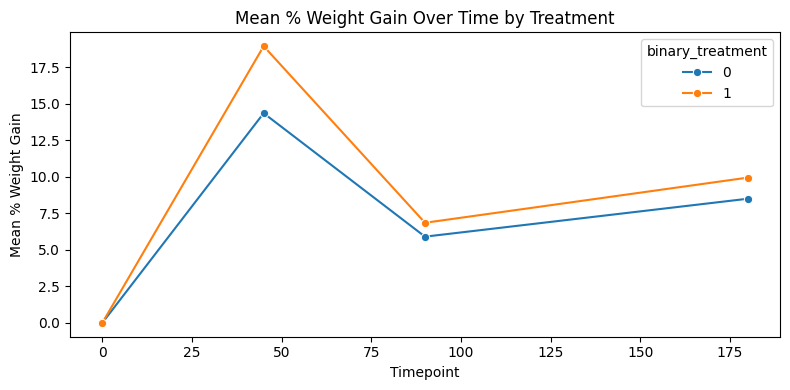

In [ ]:
# Outcome trajectory over time
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df.groupby(['timepoint', 'binary_treatment'])['pct_weight_gain'].mean().reset_index(),
    x='timepoint', y='pct_weight_gain', hue='binary_treatment', marker="o"
)
plt.title("Mean % Weight Gain Over Time by Treatment")
plt.xlabel("Timepoint")
plt.ylabel("Mean % Weight Gain")
plt.tight_layout()
plt.show()

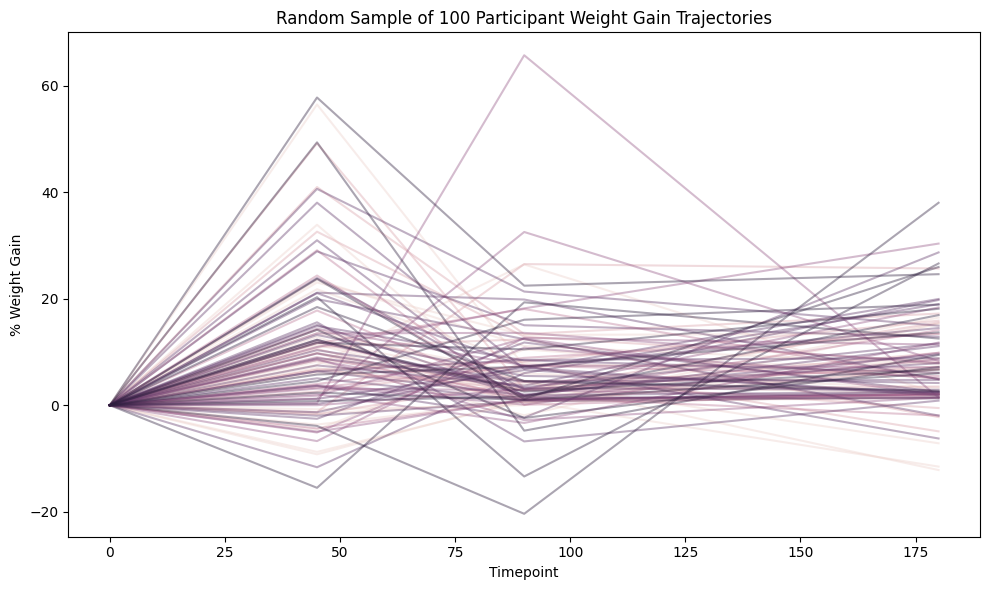

In [ ]:
# Individual Outcome trajectory over time
np.random.seed(42)

# Sample 100 random record_ids
random_ids = df['record_id'].drop_duplicates().sample(n=100, random_state=42)
df_100 = df[df['record_id'].isin(random_ids)]

# Plot individual trajectories
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_100,
    x="timepoint",
    y="pct_weight_gain",
    hue="record_id",
    legend=False,
    alpha=0.4
)
plt.title("Random Sample of 100 Participant Weight Gain Trajectories")
plt.xlabel("Timepoint")
plt.ylabel("% Weight Gain")
plt.tight_layout()
plt.show()

## Explore extreme weight gain vars

In [74]:
# Identify individuals with extreme percent weight gain
extreme_ids = data_imp.loc[
    (data_imp["pct_weight_gain"] >= 80) | (data_imp["pct_weight_gain"] <= -50),
    "record_id"
].unique()

# Subset and sort all timepoints for those individuals
extreme_trajectories = data_imp[data_imp["record_id"].isin(extreme_ids)].copy()
extreme_trajectories = extreme_trajectories.sort_values(by=["record_id", "timepoint"]).reset_index(drop=True)

# Columns to inspect
cols_to_view = [
    "record_id", "timepoint", "weight", "pct_weight_gain",
    "site", "group_adm", "agemons", "muac", "height", "oedema",
    "onoutpfeed_prog", "nutri_prog_disch", "nutri_counsel_disch", "missed_visit"
]

# View the data
extreme_trajectories_display = extreme_trajectories[cols_to_view]


In [75]:
""" pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30) """
extreme_trajectories_display

,record_id,timepoint,weight,pct_weight_gain,site,group_adm,agemons,muac,height,oedema,onoutpfeed_prog,nutri_prog_disch,nutri_counsel_disch,missed_visit
0,10001033,0,3.160000,0.000000,Kilifi,SAM,2.33,10.050000,50.150000,None,No Feeding program,None,Yes,0
1,10001033,45,3.760000,18.987342,Kilifi,SAM,3.81,11.000000,52.800000,None,No Feeding program,None,Yes,0
2,10001033,90,4.320000,14.893617,Kilifi,SAM,5.29,12.000000,54.700000,None,No Feeding program,None,Yes,0
3,10001033,180,7.985273,84.844272,Kilifi,SAM,8.24,13.364497,71.305304,None,No Feeding program,None,Yes,0
4,10001057,0,2.810000,0.000000,Kilifi,SAM,5.42,7.850000,51.550000,None,RUTF for SAM,Therapeutic,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,60001409,180,7.710000,6.639004,Banfora,SAM,29.04,11.900000,79.900000,None,No Feeding program,Therapeutic,Yes,0
344,60001430,0,3.460000,0.000000,Banfora,SAM,2.27,9.000000,54.850000,None,No Feeding program,None,Yes,0
345,60001430,45,7.560031,118.498008,Banfora,SAM,3.75,12.737612,70.889095,None,No Feeding program,None,Yes,1
346,60001430,90,7.642070,1.085171,Banfora,SAM,5.23,12.784708,71.271465,None,No Feeding program,None,Yes,1


Transform the response then see the impact

In [76]:
data_imp.columns

Index(['record_id', 'timepoint', 'group_adm', 'adm_dead', 'sex', 'agemons',
       'site', 'country', 'region', 'nutri_prog_disch', 'nutri_counsel_disch',
       'weight', 'height', 'muac', 'oedema', 'vomiting', 'fever', 'diarrhoea',
       'cough', 'notfeeding', 'poorfeeding', 'onoutpfeed_prog',
       'has_day0_and_day45', 'missed_visit', 'binary_treatment',
       'pct_weight_gain'],
      dtype='object')

In [77]:
long_data_modeling = data_imp.drop(columns=['adm_dead'])

In [78]:
# long_data_modeling.to_csv("../data/real_data_clean.csv", index=False)

## Causal Inference guided EDA (For Observational Data)
1. Positivity Checks
2. Covariate balance assessments: Informs exchangeability assumption
3. Censoring/ dropout analysis
4. Target trial specification

### Start with Target trial emulation

In [ ]:
# Define eligibility
# Copy the working dataset
df_trial = long_data_modeling.copy()

# Keep only participants aged 2–23 months at baseline (timepoint 0).
eligible_ids = df_trial.loc[
    (df_trial["timepoint"] == 0) & (df_trial["agemons"].between(2, 24)),
    "record_id"
].unique()

# Restrict dataset to eligible participants: Monotone missingness is permitted.
df_trial = df_trial[df_trial["record_id"].isin(eligible_ids)]

# Must have attended both Day 0 and Day 45: For outcome calculation(weight_now minus weight_previous).
df_trial = df_trial[df_trial["has_day0_and_day45"] == 1]

# Define baseline-only covariates.
baseline_only_vars = ["record_id", "site", "region", "group_adm", "nutri_counsel_disch"]
df_baseline = df_trial[df_trial["timepoint"] == 0][baseline_only_vars].copy()

# Rename for baseline distinction.
cols_to_rename = {col: f"{col}_day0" for col in df_baseline.columns if col != "record_id"}
df_baseline = df_baseline.rename(columns=cols_to_rename)

# Merge baseline covariates back into full dataset
df_trial = df_trial.merge(df_baseline, on="record_id", how="left")

# Restrict to key follow-up visits: Not really required since the trial only had the 4 valid visits)
df_trial = df_trial[df_trial["timepoint"].isin([0, 45, 90, 180])].copy()

df_trial.drop(columns=["site_day0", "region_day0", "group_adm_day0", "nutri_counsel_disch_day0"], inplace=True)


boys_0_2 = pd.read_csv("WHO_wfh/wfl_boys_0-to-2-years_zscores.csv")
girls_0_2 = pd.read_csv("WHO_wfh/wfl_girls_0-to-2-years_zscores.csv")
boys_2_5 = pd.read_csv("WHO_wfh/wfh_boys_2-to-5-years_zscores.csv")
girls_2_5 = pd.read_csv("WHO_wfh/wfh_girls_2-to-5-years_zscores.csv")

# Rename 'Length' to 'Height' so we can treat uniformly
for df in [boys_0_2, girls_0_2]:
    df.rename(columns={"Length": "Height"}, inplace=True)

# LMS lookup
lms_tables = {
    "boys_0_2": boys_0_2,
    "girls_0_2": girls_0_2,
    "boys_2_5": boys_2_5,
    "girls_2_5": girls_2_5
}

def get_lms(sex, age_months, height, lms_tables):
    """
    Retrieve interpolated LMS values from the correct LMS table.
    No age filtering — LMS tables are height-based.
    """
    group = "boys" if sex == "Male" else "girls" if sex == "Female" else None
    if group is None:
        return None, None, None

    table_key = f"{group}_0_2" if age_months < 24 else f"{group}_2_5"
    lms_df = lms_tables.get(table_key)

    if lms_df is None:
        return None, None, None

    try:
        L_interp = interp1d(lms_df["Height"], lms_df["L"], fill_value="extrapolate")
        M_interp = interp1d(lms_df["Height"], lms_df["M"], fill_value="extrapolate")
        S_interp = interp1d(lms_df["Height"], lms_df["S"], fill_value="extrapolate")

        return float(L_interp(height)), float(M_interp(height)), float(S_interp(height))
    except Exception:
        return None, None, None

def calculate_whz(sex, age_months, weight, height, lms_tables):
    """
    Compute WHZ using WHO LMS reference tables.
    """
    if pd.isna(sex) or pd.isna(age_months) or pd.isna(weight) or pd.isna(height):
        return np.nan

    try:
        L, M, S = get_lms(sex, age_months, height, lms_tables)
        if any(val is None for val in [L, M, S]):
            return np.nan
        z = ((weight / M) ** L - 1) / (L * S)
        return z
    except Exception:
        return np.nan


df_trial["whz"] = df_trial.apply(
    lambda row: calculate_whz(
        sex=row["sex"],
        age_months=row["agemons"],
        weight=row["weight"],
        height=row["height"],
        lms_tables=lms_tables
    ),
    axis=1
)

df_trial["poor_feeding"] = np.where(
    (df_trial["notfeeding"] == "Yes") | (df_trial["poorfeeding"] == "Yes"),
    "Yes", "No"
)

df_trial["acutely_ill"] = np.where(
    (df_trial["vomiting"] == "Yes") | (df_trial["diarrhoea"] == "Yes") | (df_trial["cough"] == "Yes"),
    "Yes", "No"
)

conditions = [
    (df_trial["whz"] < -3) | (df_trial["muac"] < 11.5),
    ((df_trial["whz"] >= -3) & (df_trial["whz"] < -2)) | ((df_trial["muac"] >= 11.5) & (df_trial["muac"] < 12.5))
]
choices = ["SAM", "MAM"]
df_trial["feed_outcome"] = np.select(conditions, choices, default="Normal")

bins = [0, 6, 12, 18, 24, 30.1]  # upper limit slightly above max age
labels = [
    "0-6 months",
    "6-12 months",
    "12-18 months",
    "18-24 months",
    "24-30 months"
]

df_trial["age_group"] = pd.cut(df_trial["agemons"], bins=bins, labels=labels, right=False)

target_cols= ['record_id', 'timepoint', 'sex', 'site', 'country', 'region', 'agemons', 'age_group', 'fever',
              'nutri_counsel_disch', 'poor_feeding', 'acutely_ill', 'binary_treatment',
              'onoutpfeed_prog', 'missed_visit', 'feed_outcome', 'pct_weight_gain']
df_target1 = df_trial[target_cols].copy()

df_target = df_target1[df_target1["record_id"].isin(selected_ids)].copy()
df_target['age_group'] = df_target['age_group'].astype('object')

In [80]:
# Collapse treatment labels into binary: 0 = no feeding, 1 = any feeding
long_data_modeling2=df_target.copy()

In [81]:
long_data_modeling2['binary_treatment'].value_counts()

binary_treatment
0    9604
1    1276
Name: count, dtype: int64

## Propensity Score modeling [Positivity check]

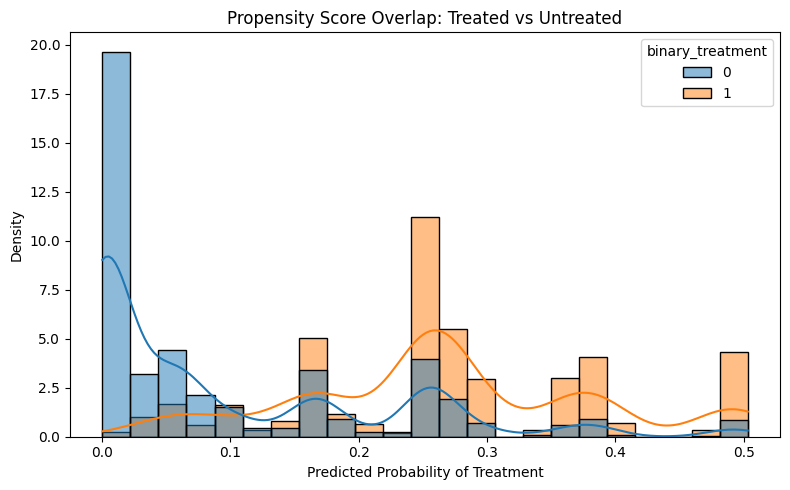

min                0.0001
max                0.5032
mean               0.1173
25%                0.0023
75%                0.2449
pct_below_0.05    45.6066
pct_above_0.95     0.0000
dtype: float64


In [82]:
# Define treatment and high-impact confounders
treatment_col = 'binary_treatment'
confounders = [
    'sex', 'site', 'region', 'age_group',
    'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
]


df_bin = long_data_modeling2.copy()

# Manually add interaction terms


required_cols = confounders + [treatment_col]
df_bin = df_bin.dropna(subset=required_cols)

X = df_bin[confounders]
y = df_bin[treatment_col]

# Build and fit pipeline with XGBoost
""" pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=300, max_depth=3))
]) """
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X.select_dtypes(include='number').columns.tolist()),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), X.select_dtypes(include='object').columns.tolist())
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
]) 
pipeline.fit(X, y)
pscores = pipeline.predict_proba(X)[:, 1]
df_bin['pscore'] = pscores



# Plot propensity score distribution by treatment
plt.figure(figsize=(8, 5))
sns.histplot(data=df_bin, x='pscore', hue='binary_treatment', kde=True, stat='density', common_norm=False)
plt.title('Propensity Score Overlap: Treated vs Untreated')
plt.xlabel('Predicted Probability of Treatment')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Diagnostics summary
diagnostics = {
    'min': pscores.min(),
    'max': pscores.max(),
    'mean': pscores.mean(),
    '25%': np.quantile(pscores, 0.25),
    '75%': np.quantile(pscores, 0.75),
    'pct_below_0.05': (pscores < 0.05).mean() * 100,
    'pct_above_0.95': (pscores > 0.95).mean() * 100
}
print(pd.Series(diagnostics).round(4))


Original N: 10880, Trimmed N: 7189


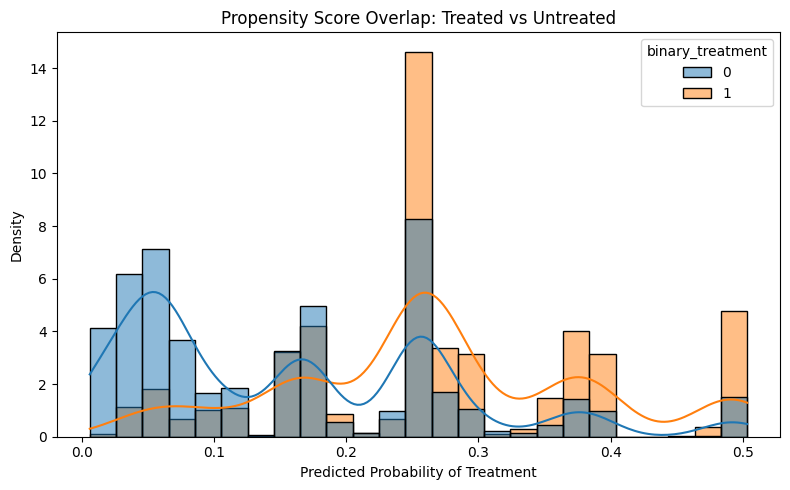

Diagnostics AFTER Trimming:
min                0.0060
max                0.5032
mean               0.1766
25%                0.0604
75%                0.2583
pct_below_0.05    17.6798
pct_above_0.95     0.0000
dtype: float64


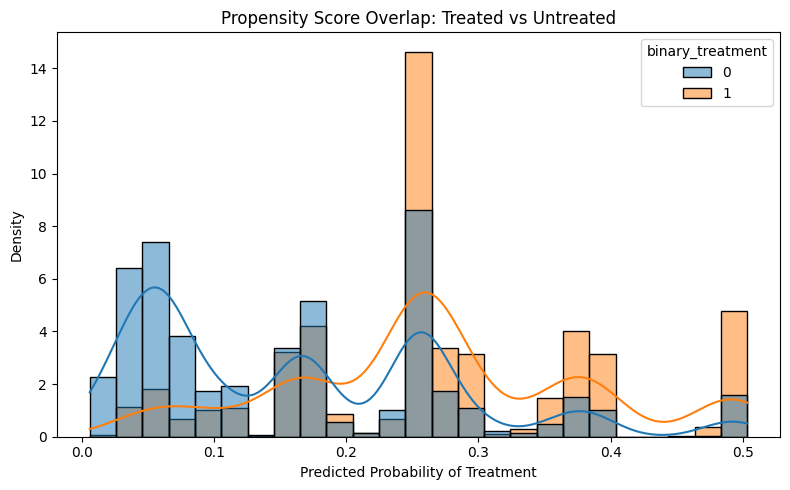

Diagnostics AFTER Trimming:
min                0.0060
max                0.5032
mean               0.1823
25%                0.0626
75%                0.2593
pct_below_0.05    14.9224
pct_above_0.95     0.0000
dtype: float64
Records with full visits: 1739
Total rows after filtering: 6956


In [ ]:
# Define treatment and high-impact confounders
treatment_col = 'binary_treatment'
confounders = [
    'sex', 'site', 'region', 'age_group',
    'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'
]


df_bin = long_data_modeling2.copy()


required_cols = confounders + [treatment_col]
df_bin = df_bin.dropna(subset=required_cols)

X = df_bin[confounders]
y = df_bin[treatment_col]

# Build and fit pipeline with XGBoost: Even worse representation
""" pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=300, max_depth=3))
]) """
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X.select_dtypes(include='number').columns.tolist()),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), X.select_dtypes(include='object').columns.tolist())
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
]) 
pipeline.fit(X, y)
pscores = pipeline.predict_proba(X)[:, 1]
df_bin['pscore'] = pscores

ps_lower = 0.005
ps_upper = 0.995

# Apply trimming
df_trimmed = df_bin[(df_bin['pscore'] >= ps_lower) & (df_bin['pscore'] <= ps_upper)].copy()

print(f"Original N: {len(df_bin)}, Trimmed N: {len(df_trimmed)}")

# Plot propensity score distribution by treatment
plt.figure(figsize=(8, 5))
sns.histplot(data=df_trimmed, x='pscore', hue='binary_treatment', kde=True, stat='density', common_norm=False)
plt.title('Propensity Score Overlap: Treated vs Untreated')
plt.xlabel('Predicted Probability of Treatment')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Diagnostics summary
pscores_trimmed = df_trimmed['pscore']

diagnostics_trimmed = {
    'min': pscores_trimmed.min(),
    'max': pscores_trimmed.max(),
    'mean': pscores_trimmed.mean(),
    '25%': np.quantile(pscores_trimmed, 0.25),
    '75%': np.quantile(pscores_trimmed, 0.75),
    'pct_below_0.05': (pscores_trimmed < 0.05).mean() * 100,
    'pct_above_0.95': (pscores_trimmed > 0.95).mean() * 100
}
print("Diagnostics AFTER Trimming:")
print(pd.Series(diagnostics_trimmed).round(4))


# Define required timepoints
required_timepoints = {0, 45, 90, 180}

# Group by record_id: check if all timepoints present
record_ids_with_full_visits = (
    df_trimmed.groupby('record_id')['timepoint']
    .agg(lambda x: set(x) == required_timepoints)
)

# Filter to record_ids that have full visits
record_ids_to_keep = record_ids_with_full_visits[record_ids_with_full_visits].index.tolist()

# Filter df_trimmed → keep only these record_ids
df_trimmed_full_visits = df_trimmed[df_trimmed['record_id'].isin(record_ids_to_keep)].copy()

# Plot propensity score distribution by treatment
plt.figure(figsize=(8, 5))
sns.histplot(data=df_trimmed_full_visits, x='pscore', hue='binary_treatment', kde=True, stat='density', common_norm=False)
plt.title('Propensity Score Overlap: Treated vs Untreated')
plt.xlabel('Predicted Probability of Treatment')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


# Diagnostics summary
pscores_trimmed1 = df_trimmed_full_visits['pscore']

diagnostics_trimmed1 = {
    'min': pscores_trimmed1.min(),
    'max': pscores_trimmed1.max(),
    'mean': pscores_trimmed1.mean(),
    '25%': np.quantile(pscores_trimmed1, 0.25),
    '75%': np.quantile(pscores_trimmed1, 0.75),
    'pct_below_0.05': (pscores_trimmed1 < 0.05).mean() * 100,
    'pct_above_0.95': (pscores_trimmed1 > 0.95).mean() * 100
}
print("Diagnostics AFTER Trimming:")
print(pd.Series(diagnostics_trimmed1).round(4))
# Report
print(f"Records with full visits: {len(record_ids_to_keep)}")
print(f"Total rows after filtering: {len(df_trimmed_full_visits)}")

## IPTW

In [84]:
# Stabilized weights
df_bin2 = df_trimmed_full_visits.copy()
""" treat = df_bin2['binary_treatment']
pscore = df_bin2['pscore']
p_treated = treat.mean()  # Marginal P(T=1)
p_control = 1 - p_treated

df_bin2['iptw'] = np.where(
    treat == 1,
    p_treated / pscore,
    p_control / (1 - pscore)
) """

" treat = df_bin2['binary_treatment']\npscore = df_bin2['pscore']\np_treated = treat.mean()  # Marginal P(T=1)\np_control = 1 - p_treated\n\ndf_bin2['iptw'] = np.where(\n    treat == 1,\n    p_treated / pscore,\n    p_control / (1 - pscore)\n) "

In [85]:
df_bin2

,record_id,timepoint,sex,site,country,region,agemons,age_group,fever,nutri_counsel_disch,poor_feeding,acutely_ill,binary_treatment,onoutpfeed_prog,missed_visit,feed_outcome,pct_weight_gain,pscore
0,10001001,0,Male,Kilifi,Kenya,Sub-Saharan Africa,23.49,18-24 months,Yes,Yes,No,No,0,No Feeding program,0,SAM,0.000000,0.298089
1,10001001,45,Male,Kilifi,Kenya,Sub-Saharan Africa,24.97,24-30 months,No,Yes,No,No,0,No Feeding program,0,MAM,15.050167,0.202667
2,10001001,90,Male,Kilifi,Kenya,Sub-Saharan Africa,26.45,24-30 months,Yes,Yes,No,Yes,0,No Feeding program,0,MAM,-0.193798,0.130385
3,10001001,180,Male,Kilifi,Kenya,Sub-Saharan Africa,29.40,24-30 months,Yes,Yes,No,No,0,No Feeding program,0,MAM,7.766990,0.202667
4,10001002,0,Male,Kilifi,Kenya,Sub-Saharan Africa,8.08,6-12 months,Yes,No,No,No,0,No Feeding program,0,Normal,0.000000,0.071775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11671,60001440,180,Male,Banfora,Burkina Faso,Sub-Saharan Africa,15.86,12-18 months,No,Yes,No,No,0,No Feeding program,0,MAM,6.979866,0.255975
11672,60001441,0,Male,Banfora,Burkina Faso,Sub-Saharan Africa,10.61,6-12 months,Yes,No,Yes,Yes,0,No Feeding program,0,SAM,0.000000,0.033775
11673,60001441,45,Male,Banfora,Burkina Faso,Sub-Saharan Africa,12.09,12-18 months,No,No,No,No,1,RUSF for MAM,0,MAM,17.452830,0.060424
11674,60001441,90,Male,Banfora,Burkina Faso,Sub-Saharan Africa,13.57,12-18 months,No,No,No,No,0,No Feeding program,0,Normal,11.378849,0.060424


## Covariate Balance Assessment
Goal: Assess whether observed covariates are balanced across treatment groups, which informs the exchangeability assumption.

We'll:

* Compute standardized mean differences (SMDs) for each covariate across treatment arms,

* Visualize balance before any adjustment (e.g., weighting),

* Compare before vs. after IPTW.

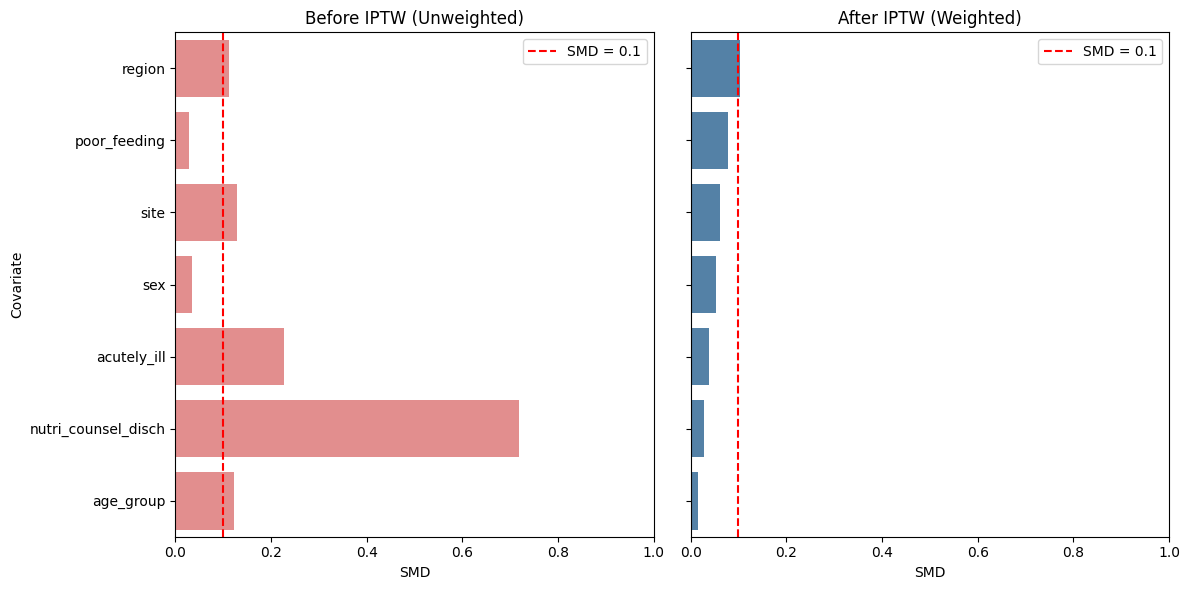

In [ ]:
# Define covariates and treatment column
covariates = ['sex', 'site', 'region', 'age_group',
              'nutri_counsel_disch', 'poor_feeding', 'acutely_ill'] 
treatment_col = "binary_treatment"
pscore_col = "pscore"

# Drop rows with missing treatment or covariates
df_bal = df_bin2.dropna(subset=covariates + [treatment_col, pscore_col]).copy()

# Compute stabilized IPTW weights
p_treated = df_bal[treatment_col].mean()
df_bal["iptw"] = np.where(
    df_bal[treatment_col] == 1,
    p_treated / df_bal[pscore_col],
    (1 - p_treated) / (1 - df_bal[pscore_col])
)


# Define helper functions for weighted SMDs
def compute_smd_numeric_weighted(col, df, treatment, weight):
    g1 = df[df[treatment] == 1]
    g0 = df[df[treatment] == 0]
    m1 = np.average(g1[col], weights=g1[weight])
    m0 = np.average(g0[col], weights=g0[weight])
    v1 = np.average((g1[col] - m1)**2, weights=g1[weight])
    v0 = np.average((g0[col] - m0)**2, weights=g0[weight])
    return abs(m1 - m0) / np.sqrt((v1 + v0) / 2)

def compute_smd_categorical_weighted(col, df, treatment, weight):
    g1 = df[df[treatment] == 1]
    g0 = df[df[treatment] == 0]
    levels = df[col].dropna().unique()
    smds = []
    for lvl in levels:
        p1 = np.average(g1[col] == lvl, weights=g1[weight])
        p0 = np.average(g0[col] == lvl, weights=g0[weight])
        pooled = (p1 * (1 - p1) + p0 * (1 - p0)) / 2
        smd = abs(p1 - p0) / np.sqrt(pooled) if pooled > 0 else 0
        smds.append(smd)
    return np.mean(smds)

df_bal["unweighted"] = 1.0
# Unweighted SMDs
smd_results_unweighted = []
for col in covariates:
    if df_bal[col].dtype == "object":
        smd = compute_smd_categorical_weighted(col, df_bal, treatment_col, "unweighted")
    else:
        smd = compute_smd_numeric_weighted(col, df_bal, treatment_col, "unweighted")
    smd_results_unweighted.append({"covariate": col, "smd": smd})

smd_df_unweighted = pd.DataFrame(smd_results_unweighted)

# Compute weighted SMDs
smd_results = []
for col in covariates:
    if df_bal[col].dtype == "object":
        smd = compute_smd_categorical_weighted(col, df_bal, treatment_col, "iptw")
    else:
        smd = compute_smd_numeric_weighted(col, df_bal, treatment_col, "iptw")
    smd_results.append({"covariate": col, "smd": smd})

smd_df = pd.DataFrame(smd_results)

smd_df_sorted = smd_df.sort_values(by="smd", ascending=False)
ordered_covariates = smd_df_sorted["covariate"]

# Reorder unweighted to match the same order
smd_df_unweighted["covariate"] = pd.Categorical(
    smd_df_unweighted["covariate"], categories=ordered_covariates, ordered=True
)
smd_df_sorted["covariate"] = pd.Categorical(
    smd_df_sorted["covariate"], categories=ordered_covariates, ordered=True
)

# Prepare figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Unweighted SMDs (left)
sns.barplot(ax=axes[0], data=smd_df_unweighted, x="smd", y="covariate", color="lightcoral")
axes[0].axvline(0.1, linestyle="--", color="red", label="SMD = 0.1")
axes[0].set_title("Before IPTW (Unweighted)")
axes[0].set_xlabel("SMD")
axes[0].set_ylabel("Covariate")
axes[0].set_xlim(0, 1)
axes[0].legend()

# Weighted SMDs (right)
sns.barplot(ax=axes[1], data=smd_df_sorted, x="smd", y="covariate", color="steelblue")
axes[1].axvline(0.1, linestyle="--", color="red", label="SMD = 0.1")
axes[1].set_title("After IPTW (Weighted)")
axes[1].set_xlabel("SMD")
axes[1].set_ylabel("") 
axes[1].set_xlim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()


In [87]:
df_bal

,record_id,timepoint,sex,site,country,region,agemons,age_group,fever,nutri_counsel_disch,poor_feeding,acutely_ill,binary_treatment,onoutpfeed_prog,missed_visit,feed_outcome,pct_weight_gain,pscore,iptw,unweighted
0,10001001,0,Male,Kilifi,Kenya,Sub-Saharan Africa,23.49,18-24 months,Yes,Yes,No,No,0,No Feeding program,0,SAM,0.000000,0.298089,1.164364,1.0
1,10001001,45,Male,Kilifi,Kenya,Sub-Saharan Africa,24.97,24-30 months,No,Yes,No,No,0,No Feeding program,0,MAM,15.050167,0.202667,1.025018,1.0
2,10001001,90,Male,Kilifi,Kenya,Sub-Saharan Africa,26.45,24-30 months,Yes,Yes,No,Yes,0,No Feeding program,0,MAM,-0.193798,0.130385,0.939819,1.0
3,10001001,180,Male,Kilifi,Kenya,Sub-Saharan Africa,29.40,24-30 months,Yes,Yes,No,No,0,No Feeding program,0,MAM,7.766990,0.202667,1.025018,1.0
4,10001002,0,Male,Kilifi,Kenya,Sub-Saharan Africa,8.08,6-12 months,Yes,No,No,No,0,No Feeding program,0,Normal,0.000000,0.071775,0.880476,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11671,60001440,180,Male,Banfora,Burkina Faso,Sub-Saharan Africa,15.86,12-18 months,No,Yes,No,No,0,No Feeding program,0,MAM,6.979866,0.255975,1.098458,1.0
11672,60001441,0,Male,Banfora,Burkina Faso,Sub-Saharan Africa,10.61,6-12 months,Yes,No,Yes,Yes,0,No Feeding program,0,SAM,0.000000,0.033775,0.845848,1.0
11673,60001441,45,Male,Banfora,Burkina Faso,Sub-Saharan Africa,12.09,12-18 months,No,No,No,No,1,RUSF for MAM,0,MAM,17.452830,0.060424,3.023980,1.0
11674,60001441,90,Male,Banfora,Burkina Faso,Sub-Saharan Africa,13.57,12-18 months,No,No,No,No,0,No Feeding program,0,Normal,11.378849,0.060424,0.869839,1.0


## Censoring/ dropout analysis [**IPCW]

Plot missing by covariates first

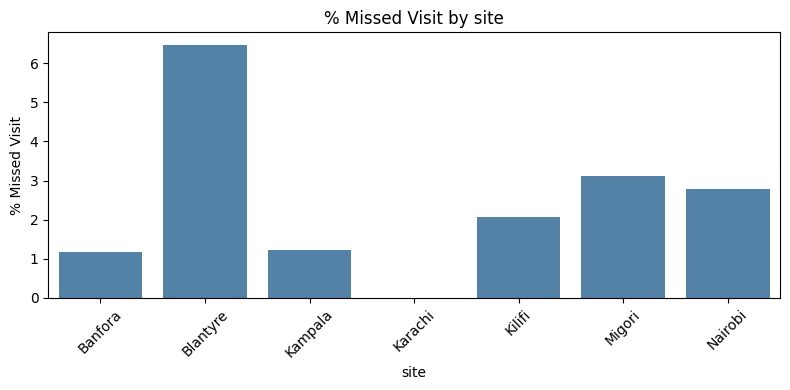

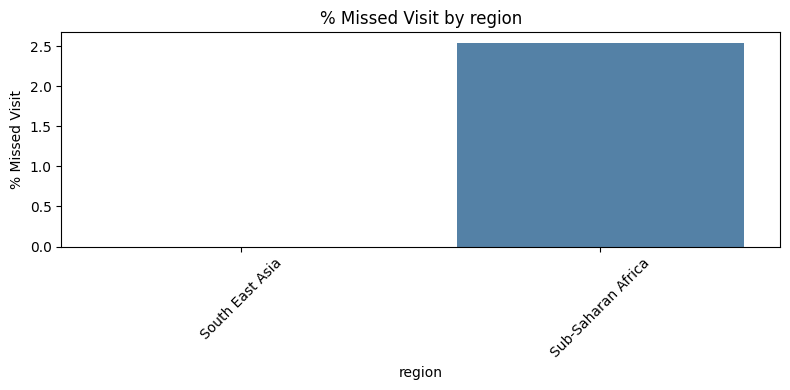

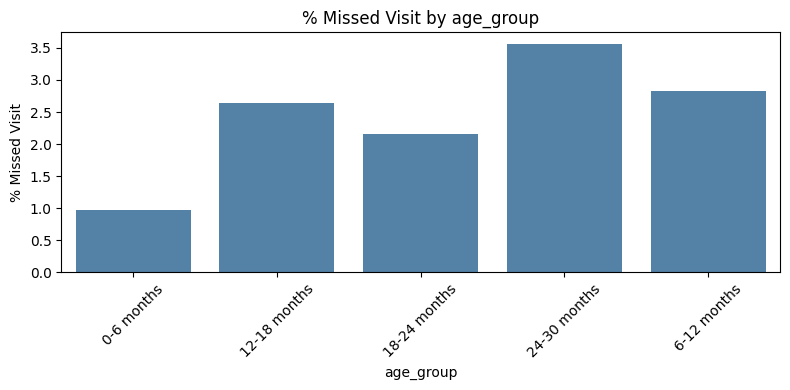

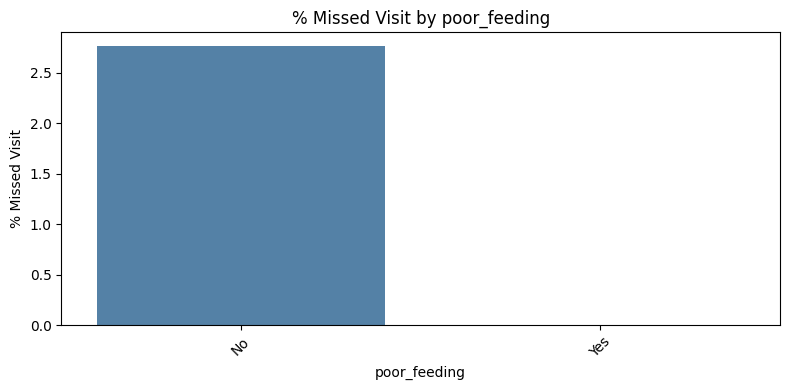

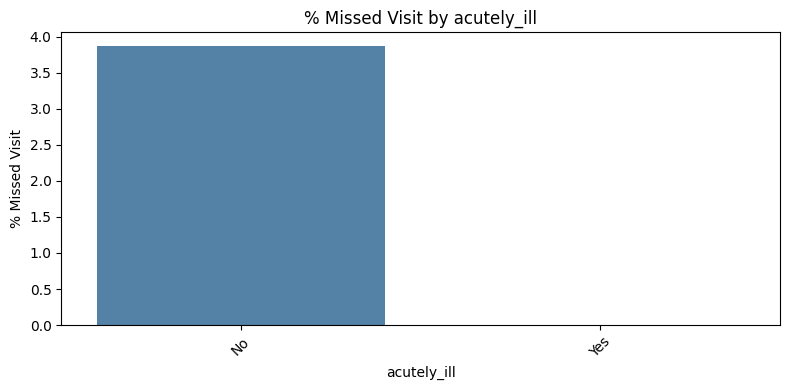

In [88]:
censoring_covariates = [
    'site', 'region', 'age_group', 'poor_feeding', 'acutely_ill'
]

# Plot % missed per covariate level
for covariate in censoring_covariates:
    df_grouped = df_bal.groupby(covariate)['missed_visit'].mean().reset_index()
    df_grouped['pct_missed'] = df_grouped['missed_visit'] * 100
    
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_grouped, x=covariate, y='pct_missed', color='steelblue')
    plt.title(f'% Missed Visit by {covariate}')
    plt.ylabel('% Missed Visit')
    plt.xlabel(covariate)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [93]:
# Prepare X and y
X_censor = df_bal[censoring_covariates]
y_censor = df_bal['missed_visit']

# Build pipeline
preprocessor_censor = ColumnTransformer([
    ('num', StandardScaler(), X_censor.select_dtypes(include='number').columns.tolist()),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), X_censor.select_dtypes(include='object').columns.tolist())
])

pipeline_censor = Pipeline([
    ('preprocessor', preprocessor_censor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit model
pipeline_censor.fit(X_censor, y_censor)

# Get coefficients
feature_names = pipeline_censor.named_steps['preprocessor'].get_feature_names_out()
coef = pipeline_censor.named_steps['classifier'].coef_[0]

# Convert to OR and CI
or_df = pd.DataFrame({
    'Feature': feature_names,
    'Log Odds': coef,
    'OR': np.exp(coef)
})

or_df = or_df.sort_values(by='OR', ascending=False)
print(or_df.round(3))


                           Feature  Log Odds     OR
0               cat__site_Blantyre     1.557  4.746
5                cat__site_Nairobi     0.784  2.190
4                 cat__site_Migori     0.715  2.044
10      cat__age_group_6-12 months     0.632  1.882
9      cat__age_group_24-30 months     0.566  1.761
7      cat__age_group_12-18 months     0.517  1.677
3                 cat__site_Kilifi     0.256  1.292
8      cat__age_group_18-24 months     0.249  1.283
6   cat__region_Sub-Saharan Africa     0.103  1.108
1                cat__site_Kampala    -0.055  0.946
2                cat__site_Karachi    -0.704  0.494
11           cat__poor_feeding_Yes    -1.556  0.211
12            cat__acutely_ill_Yes    -3.321  0.036


In [108]:
def summarize_dataframe(df):
    summary = []

    for col in df.columns:
        dtype = df[col].dtype
        n_unique = df[col].nunique(dropna=True)

        if dtype == 'object' or df[col].dtype.name == 'category':
            levels = df[col].dropna().unique()
            levels_preview = ', '.join(map(str, levels[:5]))  # Show first 5 levels
            if n_unique > 5:
                levels_preview += f", ... (+{n_unique - 5} more)"
        else:
            levels_preview = ""

        summary.append({
            "Variable": col,
            "Type": dtype.name,
            "Unique Values": n_unique,
            "Levels (if categorical)": levels_preview
        })

    return pd.DataFrame(summary)

In [109]:
pd.set_option('display.max_colwidth', None) 
dftrialcols = summarize_dataframe(df_bal)
dftrialcols

,Variable,Type,Unique Values,Levels (if categorical)
0,record_id,int64,1739,
1,timepoint,int32,4,
2,sex,object,2,"Male, Female"
3,site,object,7,"Kilifi, Nairobi, Migori, Kampala, Blantyre, ... (+2 more)"
4,country,object,5,"Kenya, Uganda, Malawi, Pakistan, Burkina Faso"
5,region,object,2,"Sub-Saharan Africa, South East Asia"
6,agemons,float64,1206,
7,age_group,object,5,"18-24 months, 24-30 months, 6-12 months, 12-18 months, 0-6 months"
8,fever,object,2,"Yes, No"
9,nutri_counsel_disch,object,2,"Yes, No"


In [120]:
df_bal.columns

Index(['record_id', 'timepoint', 'sex', 'site', 'country', 'region', 'agemons',
       'age_group', 'fever', 'nutri_counsel_disch', 'poor_feeding',
       'acutely_ill', 'binary_treatment', 'onoutpfeed_prog', 'missed_visit',
       'feed_outcome', 'pct_weight_gain', 'pscore', 'iptw'],
      dtype='object')

In [117]:
df_bal = df_bal.reset_index(drop=True)

In [130]:
# Reset index first!
# df_bal = df_bal.reset_index(drop=True)

# Define variables
columns = ['sex', 'site', 'region', 'age_group', 'feed_outcome']
categorical = ['sex', 'site', 'region', 'age_group', 'feed_outcome']

# Loop over binary_outcome levels
for b in sorted(df_bal['binary_treatment'].unique()):
    print(f"\n### Table for binary_treatment = {b}\n")
    df_subset = df_bal[df_bal['binary_treatment'] == b]
    
    table1 = TableOne(
        data=df_subset,
        columns=columns,
        categorical=categorical,
        groupby='timepoint',
        overall=True
    )
    
    print(table1.tabulate(tablefmt="github"))



### Table for binary_treatment = 0

|                     |                    | Missing   | Overall     | 0           | 180         | 45          | 90          |
|---------------------|--------------------|-----------|-------------|-------------|-------------|-------------|-------------|
| n                   |                    |           | 5685        | 1608        | 1492        | 1226        | 1359        |
| sex, n (%)          | Female             |           | 2499 (44.0) | 712 (44.3)  | 650 (43.6)  | 544 (44.4)  | 593 (43.6)  |
|                     | Male               |           | 3186 (56.0) | 896 (55.7)  | 842 (56.4)  | 682 (55.6)  | 766 (56.4)  |
| site, n (%)         | Banfora            |           | 1273 (22.4) | 348 (21.6)  | 335 (22.5)  | 271 (22.1)  | 319 (23.5)  |
|                     | Blantyre           |           | 817 (14.4)  | 228 (14.2)  | 214 (14.3)  | 184 (15.0)  | 191 (14.1)  |
|                     | Kampala            |           | 1474 (25.9) | 424

c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\tableone\tableone.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self._categorical] = handle_categorical_nulls(data[self._categorical], self._categorical)
c:\Users\cmuiruri\AppData\Local\anaconda3\Lib\site-packages\tableone\tableone.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self._categorical] = handle_categorical_nulls(data[self._categorical], self._categorical)


|                     |                    | Missing   | Overall      | 0           | 180         | 45          | 90          |
|---------------------|--------------------|-----------|--------------|-------------|-------------|-------------|-------------|
| n                   |                    |           | 1271         | 131         | 247         | 513         | 380         |
| sex, n (%)          | Female             |           | 581 (45.7)   | 58 (44.3)   | 120 (48.6)  | 226 (44.1)  | 177 (46.6)  |
|                     | Male               |           | 690 (54.3)   | 73 (55.7)   | 127 (51.4)  | 287 (55.9)  | 203 (53.4)  |
| site, n (%)         | Banfora            |           | 275 (21.6)   | 39 (29.8)   | 52 (21.1)   | 116 (22.6)  | 68 (17.9)   |
|                     | Blantyre           |           | 219 (17.2)   | 31 (23.7)   | 45 (18.2)   | 75 (14.6)   | 68 (17.9)   |
|                     | Kampala            |           | 246 (19.4)   | 6 (4.6)     | 28 (11.3)   | 137 